In [20]:
import torch
from dataloaders.beat import CustomDataset
from dataloaders.build_vocab import Vocab
import pickle
import numpy as np

config_file = open("camn_config.obj", 'rb') 
args = pickle.load(config_file)
args.batch_size = 16

mean_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_mean.npy"))
std_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_std.npy"))
mean_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_mean.npy"))
std_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_std.npy"))

In [21]:
train_data = CustomDataset(args, "train")
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=args.batch_size,  
    shuffle=True,  
    drop_last=True,
)

In [22]:
len(train_loader)

14857

In [23]:
val_data = CustomDataset(args, "val")
val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_size=args.batch_size,  
    shuffle=True,  
    drop_last=True,
)

In [24]:
len(val_loader)

2972

### Test A2BS SimpleNet

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scripts.Dataset import a2bsDataset
from scripts.SimpleNet import FaceGenerator
import wandb
import uuid

In [ ]:
# project = "testing"
# group = "facegenerator"
# name = "test"
# dataset_name = "beat"
# entity = "hm_gesture"
# run = wandb.init(
#         project="testing",
#         group="facegenerator",
#         name= f"{name}-{dataset_name}-{str(uuid.uuid4())[:8]}",
#         id=str(uuid.uuid4()),
#         entity=entity,
#     )
# wandb.run.save()

In [42]:
net = FaceGenerator().cuda()
optimizer = torch.optim.Adam( net.parameters(), lr=1e-4)#, weight_decay=1e-5)
train_target_loss = []
train_expressive_loss = []
train_smooth_loss = []
train_mse_loss = []
val_target_loss = []
val_expressive_loss = []
val_smooth_loss = []
val_mse_loss = []

def plot_train_val_loss():
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    axs[0].plot(train_target_loss, 'r-')
    axs[0].set_title('Target Loss')
    axs[1].plot(train_expressive_loss, 'p-')
    axs[1].set_title('Expressive Loss')
    axs[2].plot(train_smooth_loss, 'g-')
    axs[2].set_title('Smooth Loss')
    axs[3].plot(train_mse_loss, 'b-')
    axs[3].set_title('MSE Loss')
    fig.suptitle('Training Iterations', fontsize = 16)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    axs[0].plot(val_target_loss, 'r-')
    axs[0].set_title('Target Loss')
    axs[1].plot(val_expressive_loss, 'p-')
    axs[1].set_title('Expressive Loss')
    axs[2].plot(val_smooth_loss, 'g-')
    axs[2].set_title('Smooth Loss')
    axs[3].plot(val_mse_loss, 'b-')
    axs[3].set_title('MSE Loss')
    fig.suptitle('Validation Iterations', fontsize = 16)
    plt.tight_layout()
    plt.show()

In [43]:
print(len(train_data))
data = next(iter(train_loader))
in_audio = data['audio']
facial = data['facial']

237714


In [19]:
def expressive_loss_function(output, target): # max squared error over blendshape for each frame, then take the mean
    loss = torch.mean(torch.max((output - target) ** 2, dim=-1).values)
    return loss
# a = torch.tensor([[[1,2,3],[1,2,3]],[[4,5,6],[4,5,6]]]).float()
# b = torch.tensor([[[3,3,4],[2,3,4]],[[5,6,7],[5,6,7]]]).float()
# print(a.shape)
# max_square_error(a, b)

  0%|          | 0/14857 [00:00<?, ?it/s]

[0][0/14857]: [train] [target loss]: 0.35128292441368103 [exp loss]: 10.826492309570312 [smooth loss]: 0.04730844497680664 [mse]: 0.013618431893045948


  0%|          | 2/14857 [00:12<21:07:15,  5.12s/it]

[0][0/14857]: [val] [target loss]: 0.34991605699062345 [exp loss]: 9.535933365821839 [smooth loss]: 0.0012105274200439452 [mse]: 0.012380077714103157


  3%|▎         | 503/14857 [00:44<13:21, 17.92it/s] 

[0][500/14857]: [train] [target loss]: 0.36499345302581787 [exp loss]: 5.703800201416016 [smooth loss]: 0.0023346543312072754 [mse]: 0.010475805870488722


  7%|▋         | 1000/14857 [01:13<13:06, 17.63it/s]

[0][1000/14857]: [train] [target loss]: 0.24045953154563904 [exp loss]: 4.426246643066406 [smooth loss]: 0.0031983256340026855 [mse]: 0.006630545259824169


  7%|▋         | 1002/14857 [01:20<4:25:54,  1.15s/it]

[0][1000/14857]: [val] [target loss]: 0.2852042467147112 [exp loss]: 5.523568298816681 [smooth loss]: 0.0009388357400894165 [mse]: 0.00820003165574603


 10%|█         | 1504/14857 [01:50<12:53, 17.27it/s]  

[0][1500/14857]: [train] [target loss]: 0.24586191773414612 [exp loss]: 4.298738956451416 [smooth loss]: 0.0038181543350219727 [mse]: 0.007399072572128972


 13%|█▎        | 2000/14857 [02:20<13:34, 15.78it/s]

[0][2000/14857]: [train] [target loss]: 0.2968705892562866 [exp loss]: 5.945444583892822 [smooth loss]: 0.005707919597625732 [mse]: 0.008319288723832315


 13%|█▎        | 2004/14857 [02:29<3:24:15,  1.05it/s]

[0][2000/14857]: [val] [target loss]: 0.25475443474948406 [exp loss]: 4.929260252714157 [smooth loss]: 0.0036801475286483763 [mse]: 0.007418037007268643


 17%|█▋        | 2502/14857 [03:00<13:03, 15.77it/s]  

[0][2500/14857]: [train] [target loss]: 0.23964379727840424 [exp loss]: 4.111678600311279 [smooth loss]: 0.007027328014373779 [mse]: 0.008251786904434868


 20%|██        | 3000/14857 [03:31<12:29, 15.83it/s]

[0][3000/14857]: [train] [target loss]: 0.23428425192832947 [exp loss]: 3.576519250869751 [smooth loss]: 0.009329557418823242 [mse]: 0.006597725179310584


 20%|██        | 3002/14857 [03:40<4:31:33,  1.37s/it]

[0][3000/14857]: [val] [target loss]: 0.2377192735671997 [exp loss]: 5.058206496238708 [smooth loss]: 0.0068974560499191285 [mse]: 0.0069338921144794586


 24%|██▎       | 3504/14857 [04:10<11:26, 16.53it/s]  

[0][3500/14857]: [train] [target loss]: 0.2745978832244873 [exp loss]: 6.534076690673828 [smooth loss]: 0.012924492359161377 [mse]: 0.008763698251199629


 27%|██▋       | 4000/14857 [04:41<11:18, 16.00it/s]

[0][4000/14857]: [train] [target loss]: 0.25373634696006775 [exp loss]: 5.002281188964844 [smooth loss]: 0.012063801288604736 [mse]: 0.006694885161344711


 27%|██▋       | 4002/14857 [04:49<3:59:40,  1.32s/it]

[0][4000/14857]: [val] [target loss]: 0.21820162288844586 [exp loss]: 5.257005096673965 [smooth loss]: 0.009289030432701111 [mse]: 0.006390108459132475


 30%|███       | 4502/14857 [05:19<10:24, 16.58it/s]  

[0][4500/14857]: [train] [target loss]: 0.21900574862957 [exp loss]: 4.846843242645264 [smooth loss]: 0.014821946620941162 [mse]: 0.006917772879935786


 34%|███▎      | 5000/14857 [05:50<10:37, 15.46it/s]

[0][5000/14857]: [train] [target loss]: 0.168190598487854 [exp loss]: 2.7610092163085938 [smooth loss]: 0.01316368579864502 [mse]: 0.005500754706758761


 34%|███▎      | 5002/14857 [05:59<3:43:49,  1.36s/it]

[0][5000/14857]: [val] [target loss]: 0.213454275354743 [exp loss]: 4.743474225997925 [smooth loss]: 0.010941681265830994 [mse]: 0.006427326872311305


 37%|███▋      | 5504/14857 [06:31<09:38, 16.17it/s]  

[0][5500/14857]: [train] [target loss]: 0.21775543689727783 [exp loss]: 4.154904842376709 [smooth loss]: 0.01294034719467163 [mse]: 0.006592421618289151


 40%|████      | 6000/14857 [07:03<09:12, 16.02it/s]

[0][6000/14857]: [train] [target loss]: 0.2402501404285431 [exp loss]: 14.279180526733398 [smooth loss]: 0.018545866012573242 [mse]: 0.006606125666376419


 40%|████      | 6002/14857 [07:12<3:31:02,  1.43s/it]

[0][6000/14857]: [val] [target loss]: 0.20966317802667617 [exp loss]: 4.668651295900345 [smooth loss]: 0.00956169456243515 [mse]: 0.006230208493362487


 44%|████▍     | 6504/14857 [07:44<08:22, 16.64it/s]  

[0][6500/14857]: [train] [target loss]: 0.223959818482399 [exp loss]: 3.546103000640869 [smooth loss]: 0.014728426933288574 [mse]: 0.007059400108194926


 47%|████▋     | 7000/14857 [08:15<07:58, 16.40it/s]

[0][7000/14857]: [train] [target loss]: 0.22406832873821259 [exp loss]: 4.592000961303711 [smooth loss]: 0.012999773025512695 [mse]: 0.007720094808662638


 47%|████▋     | 7002/14857 [08:24<3:00:06,  1.38s/it]

[0][7000/14857]: [val] [target loss]: 0.19197059907019137 [exp loss]: 4.432533255815506 [smooth loss]: 0.011724607348442077 [mse]: 0.0057231353289718


 51%|█████     | 7504/14857 [08:55<07:20, 16.70it/s]  

[0][7500/14857]: [train] [target loss]: 0.22234340012073517 [exp loss]: 4.93120813369751 [smooth loss]: 0.011624157428741455 [mse]: 0.006468943463613176


 54%|█████▍    | 8000/14857 [09:26<07:09, 15.98it/s]

[0][8000/14857]: [train] [target loss]: 0.23687176406383514 [exp loss]: 7.311551094055176 [smooth loss]: 0.020716547966003418 [mse]: 0.00705070882971409


 54%|█████▍    | 8002/14857 [09:36<2:54:18,  1.53s/it]

[0][8000/14857]: [val] [target loss]: 0.2092498543858528 [exp loss]: 4.434672155380249 [smooth loss]: 0.016149643659591675 [mse]: 0.006032869206486824


 57%|█████▋    | 8502/14857 [10:09<06:39, 15.89it/s]  

[0][8500/14857]: [train] [target loss]: 0.21504709124565125 [exp loss]: 5.0331244468688965 [smooth loss]: 0.016450822353363037 [mse]: 0.0061891725957451404


 61%|██████    | 9000/14857 [10:41<06:30, 15.01it/s]

[0][9000/14857]: [train] [target loss]: 0.18089231848716736 [exp loss]: 4.010105609893799 [smooth loss]: 0.012645721435546875 [mse]: 0.0052915213326402795


 61%|██████    | 9002/14857 [10:50<2:17:44,  1.41s/it]

[0][9000/14857]: [val] [target loss]: 0.1956872783601284 [exp loss]: 4.364352884292603 [smooth loss]: 0.01053590327501297 [mse]: 0.005964356316215762


 64%|██████▍   | 9502/14857 [11:23<05:51, 15.25it/s]  

[0][9500/14857]: [train] [target loss]: 0.17602825164794922 [exp loss]: 2.6030938625335693 [smooth loss]: 0.015605568885803223 [mse]: 0.005293946903023862


 67%|██████▋   | 10000/14857 [11:55<04:56, 16.37it/s]

[0][10000/14857]: [train] [target loss]: 0.18504703044891357 [exp loss]: 3.5776655673980713 [smooth loss]: 0.016571342945098877 [mse]: 0.006008575191226141


 67%|██████▋   | 10002/14857 [12:04<1:54:19,  1.41s/it]

[0][10000/14857]: [val] [target loss]: 0.188216148391366 [exp loss]: 4.197965953350067 [smooth loss]: 0.012344307601451873 [mse]: 0.005657559427142514


 71%|███████   | 10502/14857 [12:37<04:37, 15.67it/s]  

[0][10500/14857]: [train] [target loss]: 0.28499990701675415 [exp loss]: 13.744624137878418 [smooth loss]: 0.013881862163543701 [mse]: 0.007217154232314059


 74%|███████▍  | 11000/14857 [13:08<04:07, 15.58it/s]

[0][11000/14857]: [train] [target loss]: 0.2301684021949768 [exp loss]: 4.586828231811523 [smooth loss]: 0.01742541790008545 [mse]: 0.007651370396775275


 74%|███████▍  | 11002/14857 [13:18<1:31:20,  1.42s/it]

[0][11000/14857]: [val] [target loss]: 0.1914055736362934 [exp loss]: 4.490067673921585 [smooth loss]: 0.014723871648311616 [mse]: 0.005746163503686516


 77%|███████▋  | 11504/14857 [13:50<03:36, 15.48it/s]  

[0][11500/14857]: [train] [target loss]: 0.19601812958717346 [exp loss]: 4.236642837524414 [smooth loss]: 0.0214882493019104 [mse]: 0.005501588481189607


 81%|████████  | 12000/14857 [14:23<03:15, 14.59it/s]

[0][12000/14857]: [train] [target loss]: 0.18332982063293457 [exp loss]: 3.6177728176116943 [smooth loss]: 0.016562461853027344 [mse]: 0.0061232286101557945


 81%|████████  | 12002/14857 [14:32<1:09:22,  1.46s/it]

[0][12000/14857]: [val] [target loss]: 0.20132432885468007 [exp loss]: 4.323316634893417 [smooth loss]: 0.014013519287109375 [mse]: 0.005861192931564962


 84%|████████▍ | 12504/14857 [15:07<02:40, 14.64it/s]  

[0][12500/14857]: [train] [target loss]: 0.22620508074760437 [exp loss]: 4.685927391052246 [smooth loss]: 0.01745474338531494 [mse]: 0.007289005560100863


 88%|████████▊ | 13000/14857 [15:40<02:07, 14.62it/s]

[0][13000/14857]: [train] [target loss]: 0.15707802772521973 [exp loss]: 3.046058177947998 [smooth loss]: 0.01894676685333252 [mse]: 0.005062353204289546


 88%|████████▊ | 13002/14857 [15:50<45:18,  1.47s/it]

[0][13000/14857]: [val] [target loss]: 0.17837716311216353 [exp loss]: 4.368031202554703 [smooth loss]: 0.014496138393878937 [mse]: 0.005428016379801046


 91%|█████████ | 13504/14857 [16:22<01:31, 14.82it/s]

[0][13500/14857]: [train] [target loss]: 0.2164759635925293 [exp loss]: 3.7054007053375244 [smooth loss]: 0.020043790340423584 [mse]: 0.006791125831608415


 94%|█████████▍| 14000/14857 [16:55<00:54, 15.65it/s]

[0][14000/14857]: [train] [target loss]: 0.21517954766750336 [exp loss]: 7.411022663116455 [smooth loss]: 0.015910983085632324 [mse]: 0.006101273736402762


 94%|█████████▍| 14002/14857 [17:04<19:51,  1.39s/it]

[0][14000/14857]: [val] [target loss]: 0.18677711576223374 [exp loss]: 4.2064960980415345 [smooth loss]: 0.015114772915840149 [mse]: 0.005462295928419161


 98%|█████████▊| 14502/14857 [17:37<00:23, 15.38it/s]

[0][14500/14857]: [train] [target loss]: 0.17027705907821655 [exp loss]: 3.506439447402954 [smooth loss]: 0.016422808170318604 [mse]: 0.004939116906317683


100%|██████████| 14857/14857 [18:00<00:00, 13.75it/s]


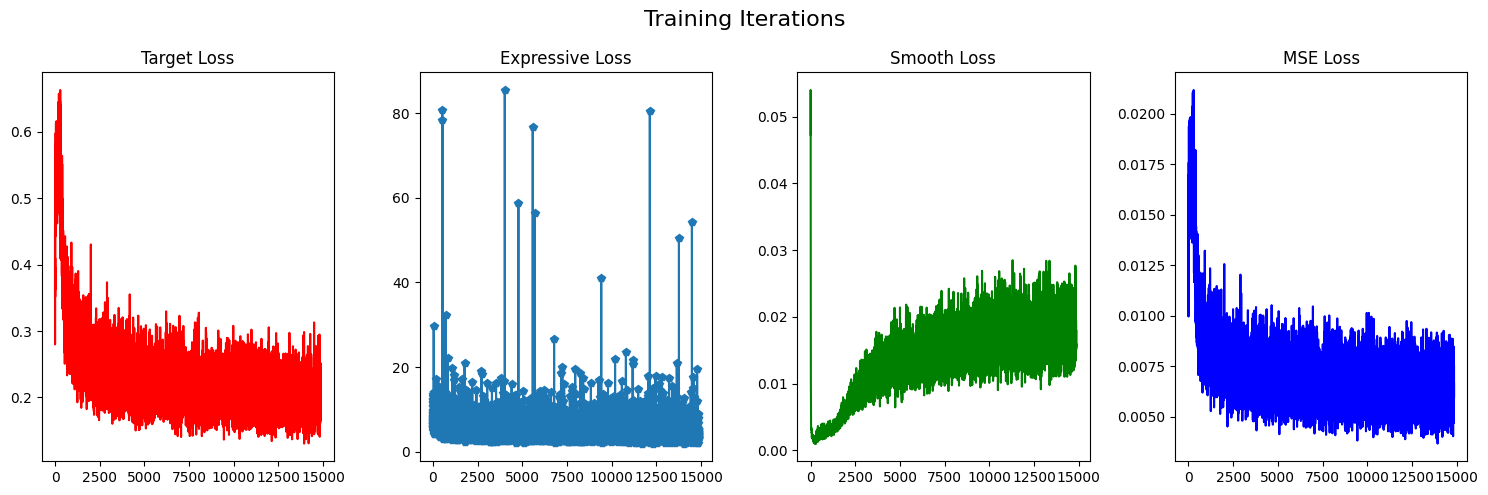

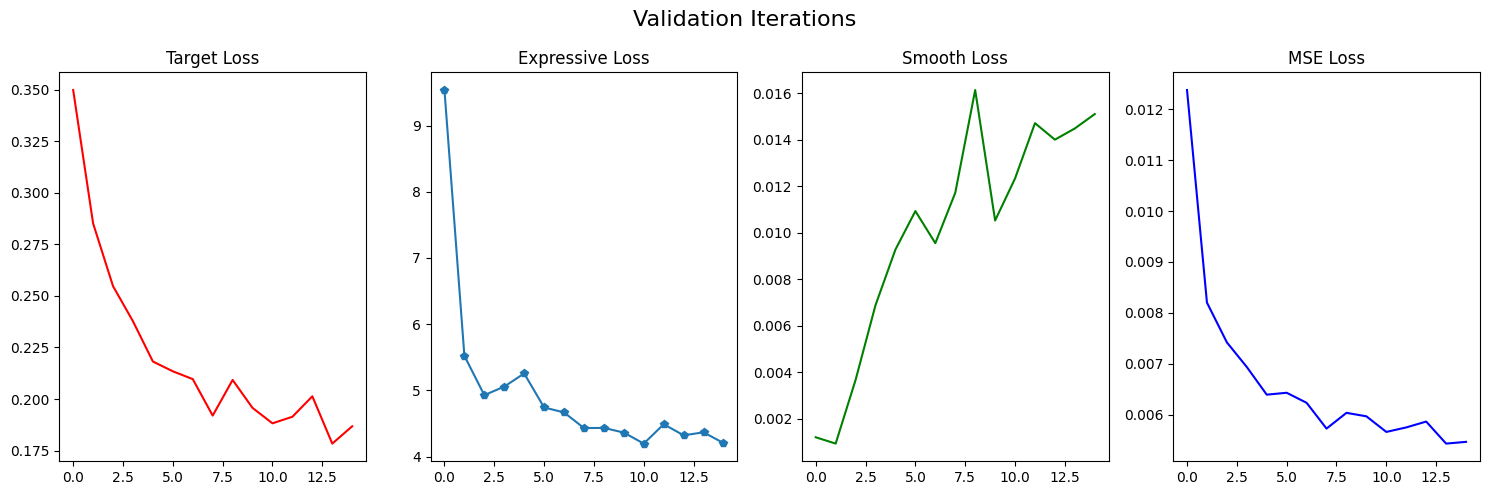

  0%|          | 0/14857 [00:00<?, ?it/s]

[1][0/14857]: [train] [target loss]: 0.17811335623264313 [exp loss]: 2.9451868534088135 [smooth loss]: 0.013724923133850098 [mse]: 0.005787727793186767


  0%|          | 2/14857 [00:10<17:24:58,  4.22s/it]

[1][0/14857]: [val] [target loss]: 0.1876715799421072 [exp loss]: 4.23667661011219 [smooth loss]: 0.01417687863111496 [mse]: 0.005645553176962055


  3%|▎         | 503/14857 [00:42<14:28, 16.53it/s] 

[1][500/14857]: [train] [target loss]: 0.2135629504919052 [exp loss]: 3.22894549369812 [smooth loss]: 0.02157360315322876 [mse]: 0.006249487657072144


  7%|▋         | 999/14857 [01:14<14:08, 16.34it/s]

[1][1000/14857]: [train] [target loss]: 0.24366708099842072 [exp loss]: 6.827565670013428 [smooth loss]: 0.01812523603439331 [mse]: 0.008002366988441957


  7%|▋         | 1001/14857 [01:23<5:24:04,  1.40s/it]

[1][1000/14857]: [val] [target loss]: 0.1833488817512989 [exp loss]: 3.967464299798012 [smooth loss]: 0.01577339679002762 [mse]: 0.005475601012914746


 10%|█         | 1503/14857 [01:55<14:06, 15.77it/s]  

[1][1500/14857]: [train] [target loss]: 0.23564183712005615 [exp loss]: 8.266766548156738 [smooth loss]: 0.017562925815582275 [mse]: 0.006944020387580614


 13%|█▎        | 1999/14857 [02:26<13:48, 15.52it/s]

[1][2000/14857]: [train] [target loss]: 0.17028561234474182 [exp loss]: 3.1630594730377197 [smooth loss]: 0.023217856884002686 [mse]: 0.005250594898971845


 13%|█▎        | 2001/14857 [02:35<5:02:23,  1.41s/it]

[1][2000/14857]: [val] [target loss]: 0.1843399015069008 [exp loss]: 4.092691793441772 [smooth loss]: 0.016621732115745545 [mse]: 0.005557175144938328


 17%|█▋        | 2503/14857 [03:08<13:41, 15.05it/s]  

[1][2500/14857]: [train] [target loss]: 0.20211663842201233 [exp loss]: 3.873323440551758 [smooth loss]: 0.019645214080810547 [mse]: 0.006491677084109364


 20%|██        | 2999/14857 [03:41<12:45, 15.49it/s]

[1][3000/14857]: [train] [target loss]: 0.16390588879585266 [exp loss]: 2.6074588298797607 [smooth loss]: 0.017552673816680908 [mse]: 0.005418102383082633


 20%|██        | 3001/14857 [03:50<4:47:34,  1.46s/it]

[1][3000/14857]: [val] [target loss]: 0.18541284792125226 [exp loss]: 4.0673613560199735 [smooth loss]: 0.01828986018896103 [mse]: 0.005476197205176312


 24%|██▎       | 3503/14857 [04:24<12:43, 14.87it/s]  

[1][3500/14857]: [train] [target loss]: 0.2173144668340683 [exp loss]: 7.733067989349365 [smooth loss]: 0.021750807762145996 [mse]: 0.006555249433285515


 27%|██▋       | 3999/14857 [04:58<11:58, 15.11it/s]

[1][4000/14857]: [train] [target loss]: 0.19681110978126526 [exp loss]: 4.0640950202941895 [smooth loss]: 0.017392218112945557 [mse]: 0.005863775793235326


 27%|██▋       | 4001/14857 [05:08<4:21:29,  1.45s/it]

[1][4000/14857]: [val] [target loss]: 0.18395351529121398 [exp loss]: 3.983590918779373 [smooth loss]: 0.016076985895633698 [mse]: 0.005548604918726638


 30%|███       | 4503/14857 [05:42<11:19, 15.23it/s]  

[1][4500/14857]: [train] [target loss]: 0.19401513040065765 [exp loss]: 3.690192699432373 [smooth loss]: 0.02440643310546875 [mse]: 0.006080316825204917


 34%|███▎      | 4999/14857 [06:15<11:00, 14.92it/s]

[1][5000/14857]: [train] [target loss]: 0.21553878486156464 [exp loss]: 3.8360981941223145 [smooth loss]: 0.018855690956115723 [mse]: 0.0067020380199497905


 34%|███▎      | 5001/14857 [06:25<3:58:29,  1.45s/it]

[1][5000/14857]: [val] [target loss]: 0.1789727396517992 [exp loss]: 4.033384793996811 [smooth loss]: 0.01668988198041916 [mse]: 0.005311742626805163


 37%|███▋      | 5503/14857 [06:58<10:10, 15.32it/s]  

[1][5500/14857]: [train] [target loss]: 0.21729053556919098 [exp loss]: 6.805335521697998 [smooth loss]: 0.014508068561553955 [mse]: 0.006575982355242726


 40%|████      | 5999/14857 [07:31<09:29, 15.56it/s]

[1][6000/14857]: [train] [target loss]: 0.16755761206150055 [exp loss]: 2.829838514328003 [smooth loss]: 0.019901573657989502 [mse]: 0.00489366280376647


 40%|████      | 6001/14857 [07:40<3:31:57,  1.44s/it]

[1][6000/14857]: [val] [target loss]: 0.19041516825556756 [exp loss]: 4.118703117370606 [smooth loss]: 0.01787798523902893 [mse]: 0.005568495260377361


 44%|████▍     | 6503/14857 [08:14<09:14, 15.06it/s]  

[1][6500/14857]: [train] [target loss]: 0.18022148311138153 [exp loss]: 5.204190254211426 [smooth loss]: 0.015561401844024658 [mse]: 0.005356065400950455


 47%|████▋     | 7000/14857 [08:49<10:48, 12.11it/s]

[1][7000/14857]: [train] [target loss]: 0.16180717945098877 [exp loss]: 3.338263511657715 [smooth loss]: 0.01978600025177002 [mse]: 0.0050104542608950964


 47%|████▋     | 7002/14857 [09:00<3:32:15,  1.62s/it]

[1][7000/14857]: [val] [target loss]: 0.17003258351236583 [exp loss]: 3.825609220266342 [smooth loss]: 0.01756123572587967 [mse]: 0.005242197074534316


 50%|█████     | 7502/14857 [09:33<08:24, 14.58it/s]  

[1][7500/14857]: [train] [target loss]: 0.22302354872226715 [exp loss]: 4.652562141418457 [smooth loss]: 0.01680546998977661 [mse]: 0.007427920647803742


 54%|█████▍    | 8000/14857 [10:06<07:21, 15.53it/s]

[1][8000/14857]: [train] [target loss]: 0.17140333354473114 [exp loss]: 3.062819004058838 [smooth loss]: 0.018297672271728516 [mse]: 0.005270258920308705


 54%|█████▍    | 8002/14857 [10:15<2:43:17,  1.43s/it]

[1][8000/14857]: [val] [target loss]: 0.18013839170336723 [exp loss]: 3.969204077720642 [smooth loss]: 0.015381678640842437 [mse]: 0.005454720925669981


 57%|█████▋    | 8504/14857 [10:48<06:44, 15.72it/s]  

[1][8500/14857]: [train] [target loss]: 0.2068922519683838 [exp loss]: 4.500214576721191 [smooth loss]: 0.01604461669921875 [mse]: 0.006492125328792986


 61%|██████    | 9000/14857 [11:21<06:27, 15.11it/s]

[1][9000/14857]: [train] [target loss]: 0.15047110617160797 [exp loss]: 2.6783952713012695 [smooth loss]: 0.0182611346244812 [mse]: 0.0044523792782125045


 61%|██████    | 9002/14857 [11:30<2:21:59,  1.46s/it]

[1][9000/14857]: [val] [target loss]: 0.1742340485751629 [exp loss]: 4.33079015135765 [smooth loss]: 0.01569317638874054 [mse]: 0.0053735926971555815


 64%|██████▍   | 9504/14857 [12:04<05:42, 15.61it/s]  

[1][9500/14857]: [train] [target loss]: 0.16928617656230927 [exp loss]: 3.217496871948242 [smooth loss]: 0.01464700698852539 [mse]: 0.004991608402582105


 67%|██████▋   | 10000/14857 [12:37<05:25, 14.91it/s]

[1][10000/14857]: [train] [target loss]: 0.18646323680877686 [exp loss]: 3.3191282749176025 [smooth loss]: 0.01913076639175415 [mse]: 0.005481059626829938


 67%|██████▋   | 10002/14857 [12:46<1:56:46,  1.44s/it]

[1][10000/14857]: [val] [target loss]: 0.17884924121201037 [exp loss]: 4.071563030481339 [smooth loss]: 0.016904318034648896 [mse]: 0.005365352024855548


 71%|███████   | 10504/14857 [13:21<05:01, 14.45it/s]  

[1][10500/14857]: [train] [target loss]: 0.19358401000499725 [exp loss]: 3.4457976818084717 [smooth loss]: 0.01852250099182129 [mse]: 0.006861087537143429


 74%|███████▍  | 10999/14857 [13:58<11:47,  5.46it/s]

[1][11000/14857]: [train] [target loss]: 0.19334231317043304 [exp loss]: 4.831590175628662 [smooth loss]: 0.02026456594467163 [mse]: 0.005406104184154696


 74%|███████▍  | 11002/14857 [14:10<1:45:56,  1.65s/it]

[1][11000/14857]: [val] [target loss]: 0.17108413662761449 [exp loss]: 3.9812587213516237 [smooth loss]: 0.016892392337322235 [mse]: 0.005196149363619805


 77%|███████▋  | 11502/14857 [14:43<03:38, 15.33it/s]  

[1][11500/14857]: [train] [target loss]: 0.21738655865192413 [exp loss]: 5.380425930023193 [smooth loss]: 0.016237378120422363 [mse]: 0.006308743050968287


 81%|████████  | 12000/14857 [15:15<03:04, 15.50it/s]

[1][12000/14857]: [train] [target loss]: 0.14445306360721588 [exp loss]: 2.570373058319092 [smooth loss]: 0.01859062910079956 [mse]: 0.004326271769492409


 81%|████████  | 12002/14857 [15:25<1:11:12,  1.50s/it]

[1][12000/14857]: [val] [target loss]: 0.1749077183008194 [exp loss]: 4.073804244399071 [smooth loss]: 0.018678453266620636 [mse]: 0.00526222655524043


 84%|████████▍ | 12504/14857 [15:57<02:34, 15.26it/s]  

[1][12500/14857]: [train] [target loss]: 0.18199867010116577 [exp loss]: 4.011157989501953 [smooth loss]: 0.017997384071350098 [mse]: 0.005516355480796784


 88%|████████▊ | 13000/14857 [16:31<02:06, 14.63it/s]

[1][13000/14857]: [train] [target loss]: 0.15918397903442383 [exp loss]: 2.7417266368865967 [smooth loss]: 0.012995362281799316 [mse]: 0.004902237414470282


 88%|████████▊ | 13002/14857 [16:41<45:50,  1.48s/it]

[1][13000/14857]: [val] [target loss]: 0.16631911240518094 [exp loss]: 3.9198591601848602 [smooth loss]: 0.016974748373031617 [mse]: 0.005137562919579184


 91%|█████████ | 13504/14857 [17:15<01:30, 14.91it/s]

[1][13500/14857]: [train] [target loss]: 0.18659460544586182 [exp loss]: 4.868463039398193 [smooth loss]: 0.022920429706573486 [mse]: 0.006935475180840219


 94%|█████████▍| 14000/14857 [17:48<00:54, 15.74it/s]

[1][14000/14857]: [train] [target loss]: 0.18684479594230652 [exp loss]: 3.9258005619049072 [smooth loss]: 0.022485852241516113 [mse]: 0.006394664284104337


 94%|█████████▍| 14002/14857 [17:58<20:19,  1.43s/it]

[1][14000/14857]: [val] [target loss]: 0.1770785516127944 [exp loss]: 3.821925333738327 [smooth loss]: 0.02010089039802551 [mse]: 0.005376199231244807


 98%|█████████▊| 14502/14857 [18:31<00:23, 15.01it/s]

[1][14500/14857]: [train] [target loss]: 0.187921941280365 [exp loss]: 3.6092936992645264 [smooth loss]: 0.016680002212524414 [mse]: 0.0061744218995696725


100%|██████████| 14857/14857 [18:54<00:00, 13.09it/s]


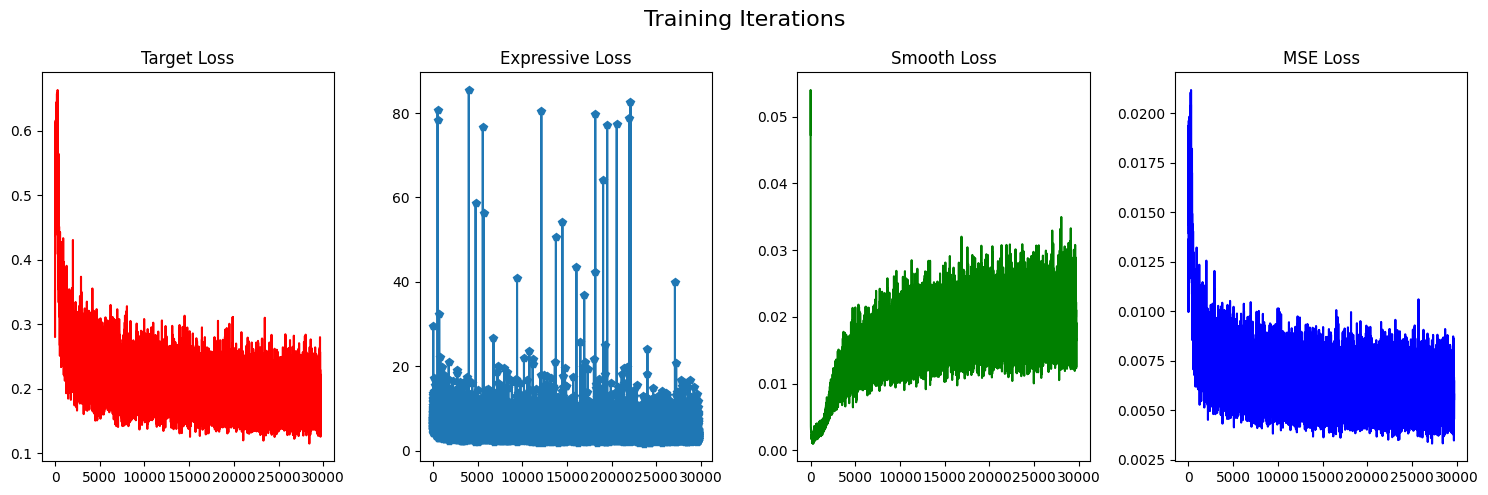

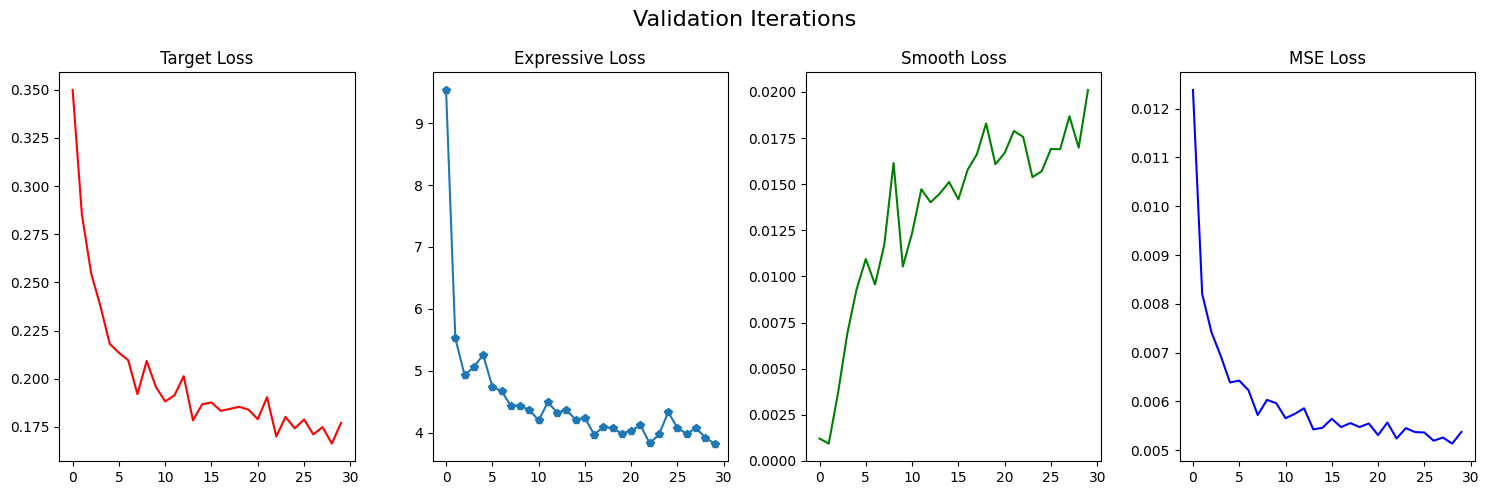

  0%|          | 0/14857 [00:00<?, ?it/s]

[2][0/14857]: [train] [target loss]: 0.19684986770153046 [exp loss]: 3.694126844406128 [smooth loss]: 0.016214072704315186 [mse]: 0.006301981748140293


  0%|          | 2/14857 [00:10<17:39:34,  4.28s/it]

[2][0/14857]: [val] [target loss]: 0.17607363775372506 [exp loss]: 4.0830354976654055 [smooth loss]: 0.017592354118824004 [mse]: 0.005301836966521678


  3%|▎         | 504/14857 [01:03<14:52, 16.08it/s]   

[2][500/14857]: [train] [target loss]: 0.18301568925380707 [exp loss]: 4.373806953430176 [smooth loss]: 0.013877034187316895 [mse]: 0.005341468099133961


  7%|▋         | 1000/14857 [01:34<15:55, 14.50it/s]

[2][1000/14857]: [train] [target loss]: 0.1704833060503006 [exp loss]: 2.8801045417785645 [smooth loss]: 0.023450195789337158 [mse]: 0.004984043792495062


  7%|▋         | 1002/14857 [01:44<5:30:55,  1.43s/it]

[2][1000/14857]: [val] [target loss]: 0.18428369253873825 [exp loss]: 4.328638000488281 [smooth loss]: 0.018555574119091034 [mse]: 0.005313422917860839


 10%|█         | 1502/14857 [02:18<15:53, 14.01it/s]  

[2][1500/14857]: [train] [target loss]: 0.13430026173591614 [exp loss]: 2.980060338973999 [smooth loss]: 0.015034019947052002 [mse]: 0.004132786858868143


 13%|█▎        | 2000/14857 [02:51<13:31, 15.85it/s]

[2][2000/14857]: [train] [target loss]: 0.16425774991512299 [exp loss]: 2.9823715686798096 [smooth loss]: 0.018520236015319824 [mse]: 0.005254359862752525
[2][2000/14857]: [val] [target loss]: 0.17242551885545254 [exp loss]: 4.273691482543946 [smooth loss]: 0.01874327003955841 [mse]: 0.005227003141992613


 17%|█▋        | 2503/14857 [03:48<13:44, 14.98it/s]  

[2][2500/14857]: [train] [target loss]: 0.17794513702392578 [exp loss]: 6.788986682891846 [smooth loss]: 0.020400285720825195 [mse]: 0.005493533659418222


 20%|██        | 2999/14857 [04:21<12:51, 15.38it/s]

[2][3000/14857]: [train] [target loss]: 0.16881193220615387 [exp loss]: 3.261915445327759 [smooth loss]: 0.02304476499557495 [mse]: 0.006083603959765891


 20%|██        | 3001/14857 [04:31<5:05:07,  1.54s/it]

[2][3000/14857]: [val] [target loss]: 0.1679377408698201 [exp loss]: 3.8251305454969406 [smooth loss]: 0.018935211896896363 [mse]: 0.005223132749115768


 24%|██▎       | 3503/14857 [05:05<13:01, 14.53it/s]  

[2][3500/14857]: [train] [target loss]: 0.14599402248859406 [exp loss]: 3.321993112564087 [smooth loss]: 0.016972720623016357 [mse]: 0.004815569652344267


 27%|██▋       | 3999/14857 [05:39<13:06, 13.80it/s]

[2][4000/14857]: [train] [target loss]: 0.1765405684709549 [exp loss]: 3.4755492210388184 [smooth loss]: 0.01951909065246582 [mse]: 0.005686296299478146


 27%|██▋       | 4002/14857 [05:50<3:56:19,  1.31s/it]

[2][4000/14857]: [val] [target loss]: 0.1676035724580288 [exp loss]: 3.8619126224517824 [smooth loss]: 0.017906697690486906 [mse]: 0.00509435633100056


 30%|███       | 4504/14857 [06:25<11:58, 14.40it/s]  

[2][4500/14857]: [train] [target loss]: 0.18159937858581543 [exp loss]: 4.0365495681762695 [smooth loss]: 0.01775193214416504 [mse]: 0.006220078059590334


 34%|███▎      | 5000/14857 [06:59<10:53, 15.09it/s]

[2][5000/14857]: [train] [target loss]: 0.19358372688293457 [exp loss]: 3.198042392730713 [smooth loss]: 0.02212601900100708 [mse]: 0.005947835074670066


 34%|███▎      | 5002/14857 [07:08<4:06:38,  1.50s/it]

[2][5000/14857]: [val] [target loss]: 0.16764466300606728 [exp loss]: 3.9598668694496153 [smooth loss]: 0.018489568531513213 [mse]: 0.005257954261424915


 37%|███▋      | 5502/14857 [07:42<10:34, 14.75it/s]  

[2][5500/14857]: [train] [target loss]: 0.17308272421360016 [exp loss]: 3.2763164043426514 [smooth loss]: 0.02405625581741333 [mse]: 0.0052477271419683865


 40%|████      | 6000/14857 [08:15<09:38, 15.31it/s]

[2][6000/14857]: [train] [target loss]: 0.22445744276046753 [exp loss]: 15.121953964233398 [smooth loss]: 0.02120840549468994 [mse]: 0.007026539062342511


 40%|████      | 6002/14857 [08:25<3:43:22,  1.51s/it]

[2][6000/14857]: [val] [target loss]: 0.16729036137461661 [exp loss]: 4.038973357081414 [smooth loss]: 0.018436859846115112 [mse]: 0.005099595251408201


 44%|████▍     | 6504/14857 [09:00<09:07, 15.27it/s]  

[2][6500/14857]: [train] [target loss]: 0.20595227181911469 [exp loss]: 3.5968847274780273 [smooth loss]: 0.024235069751739502 [mse]: 0.006261667730559853


 47%|████▋     | 7000/14857 [09:33<08:45, 14.94it/s]

[2][7000/14857]: [train] [target loss]: 0.21438327431678772 [exp loss]: 4.286806106567383 [smooth loss]: 0.027078747749328613 [mse]: 0.006447085213475463


 47%|████▋     | 7002/14857 [09:43<3:13:25,  1.48s/it]

[2][7000/14857]: [val] [target loss]: 0.16740360513329505 [exp loss]: 3.877151836156845 [smooth loss]: 0.017228457629680633 [mse]: 0.0051809986082696465


 50%|█████     | 7502/14857 [10:17<08:09, 15.02it/s]  

[2][7500/14857]: [train] [target loss]: 0.16716843843460083 [exp loss]: 2.749403715133667 [smooth loss]: 0.017434418201446533 [mse]: 0.005296064196405037


 54%|█████▍    | 8000/14857 [10:51<07:33, 15.13it/s]

[2][8000/14857]: [train] [target loss]: 0.17470084130764008 [exp loss]: 3.108508586883545 [smooth loss]: 0.01747220754623413 [mse]: 0.00556855040206277


 54%|█████▍    | 8002/14857 [11:01<2:54:12,  1.52s/it]

[2][8000/14857]: [val] [target loss]: 0.16655023291707038 [exp loss]: 4.260934816598892 [smooth loss]: 0.01879382073879242 [mse]: 0.005125077693096944


 57%|█████▋    | 8504/14857 [11:35<07:00, 15.11it/s]  

[2][8500/14857]: [train] [target loss]: 0.20394280552864075 [exp loss]: 4.234798908233643 [smooth loss]: 0.024477839469909668 [mse]: 0.007154112127998235


 61%|██████    | 9000/14857 [12:08<06:30, 15.02it/s]

[2][9000/14857]: [train] [target loss]: 0.1713169515132904 [exp loss]: 3.2656478881835938 [smooth loss]: 0.016151845455169678 [mse]: 0.005459324906493918


 61%|██████    | 9002/14857 [12:18<2:27:59,  1.52s/it]

[2][9000/14857]: [val] [target loss]: 0.16246357433497904 [exp loss]: 4.1023024761676785 [smooth loss]: 0.019043727219104765 [mse]: 0.005038554356561246


 64%|██████▍   | 9504/14857 [12:52<05:38, 15.83it/s]  

[2][9500/14857]: [train] [target loss]: 0.17743507027626038 [exp loss]: 6.305931091308594 [smooth loss]: 0.01889890432357788 [mse]: 0.0052392353431436394


 67%|██████▋   | 10000/14857 [13:25<05:25, 14.90it/s]

[2][10000/14857]: [train] [target loss]: 0.155941903591156 [exp loss]: 2.903235673904419 [smooth loss]: 0.021846771240234375 [mse]: 0.004756095772631707


 67%|██████▋   | 10002/14857 [13:35<1:59:35,  1.48s/it]

[2][10000/14857]: [val] [target loss]: 0.16457779135555028 [exp loss]: 3.9026303124427795 [smooth loss]: 0.019185622036457062 [mse]: 0.005070469973529461


 71%|███████   | 10504/14857 [14:08<04:47, 15.15it/s]  

[2][10500/14857]: [train] [target loss]: 0.19122806191444397 [exp loss]: 3.1240224838256836 [smooth loss]: 0.0196496844291687 [mse]: 0.006300858057065795


 74%|███████▍  | 11000/14857 [14:51<04:46, 13.45it/s]

[2][11000/14857]: [train] [target loss]: 0.1656443327665329 [exp loss]: 4.334753036499023 [smooth loss]: 0.01991117000579834 [mse]: 0.004615663928854091


 74%|███████▍  | 11002/14857 [15:03<1:52:26,  1.75s/it]

[2][11000/14857]: [val] [target loss]: 0.16747070953249932 [exp loss]: 3.8803344237804414 [smooth loss]: 0.019008135199546815 [mse]: 0.005191314053402548


 77%|███████▋  | 11503/14857 [15:41<04:13, 13.24it/s]  

[2][11500/14857]: [train] [target loss]: 0.17526420950889587 [exp loss]: 3.723020315170288 [smooth loss]: 0.020600497722625732 [mse]: 0.005363312219731303


 81%|████████  | 12000/14857 [16:20<03:32, 13.47it/s]

[2][12000/14857]: [train] [target loss]: 0.21151302754878998 [exp loss]: 4.307299613952637 [smooth loss]: 0.020751953125 [mse]: 0.007859213857610561


 81%|████████  | 12002/14857 [16:31<1:20:22,  1.69s/it]

[2][12000/14857]: [val] [target loss]: 0.1706471113115549 [exp loss]: 4.008295340538025 [smooth loss]: 0.01971968561410904 [mse]: 0.005167008585093822


 84%|████████▍ | 12503/14857 [17:10<03:00, 13.06it/s]  

[2][12500/14857]: [train] [target loss]: 0.16963419318199158 [exp loss]: 3.725630044937134 [smooth loss]: 0.023953616619110107 [mse]: 0.005400989853843959


 87%|████████▋ | 12999/14857 [17:48<02:18, 13.43it/s]

[2][13000/14857]: [train] [target loss]: 0.185002863407135 [exp loss]: 3.889195203781128 [smooth loss]: 0.02639329433441162 [mse]: 0.005474207680931091


 88%|████████▊ | 13002/14857 [17:59<44:49,  1.45s/it]

[2][13000/14857]: [val] [target loss]: 0.16616489723324776 [exp loss]: 3.7836568450927732 [smooth loss]: 0.017703828513622285 [mse]: 0.0051865620915682855


 91%|█████████ | 13503/14857 [18:37<02:05, 10.82it/s]

[2][13500/14857]: [train] [target loss]: 0.18417640030384064 [exp loss]: 3.231369972229004 [smooth loss]: 0.02589517831802368 [mse]: 0.005524597937527752


 94%|█████████▍| 13999/14857 [19:15<01:01, 13.85it/s]

[2][14000/14857]: [train] [target loss]: 0.18208998441696167 [exp loss]: 3.0439834594726562 [smooth loss]: 0.019527316093444824 [mse]: 0.005575593982514921


 94%|█████████▍| 14002/14857 [19:27<21:41,  1.52s/it]

[2][14000/14857]: [val] [target loss]: 0.16215998366475104 [exp loss]: 3.6424026173353194 [smooth loss]: 0.019308465123176573 [mse]: 0.00496307122212361


 98%|█████████▊| 14502/14857 [20:04<00:27, 12.86it/s]

[2][14500/14857]: [train] [target loss]: 0.1314607411623001 [exp loss]: 2.2947583198547363 [smooth loss]: 0.01933121681213379 [mse]: 0.004266432762759264


100%|██████████| 14857/14857 [20:31<00:00, 12.07it/s]


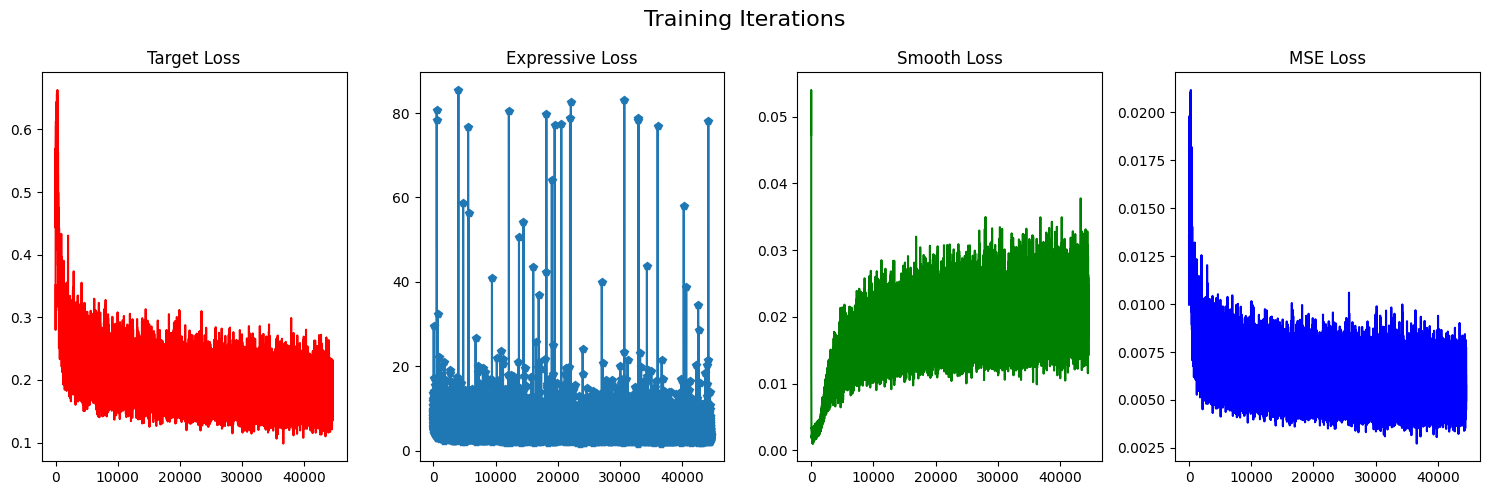

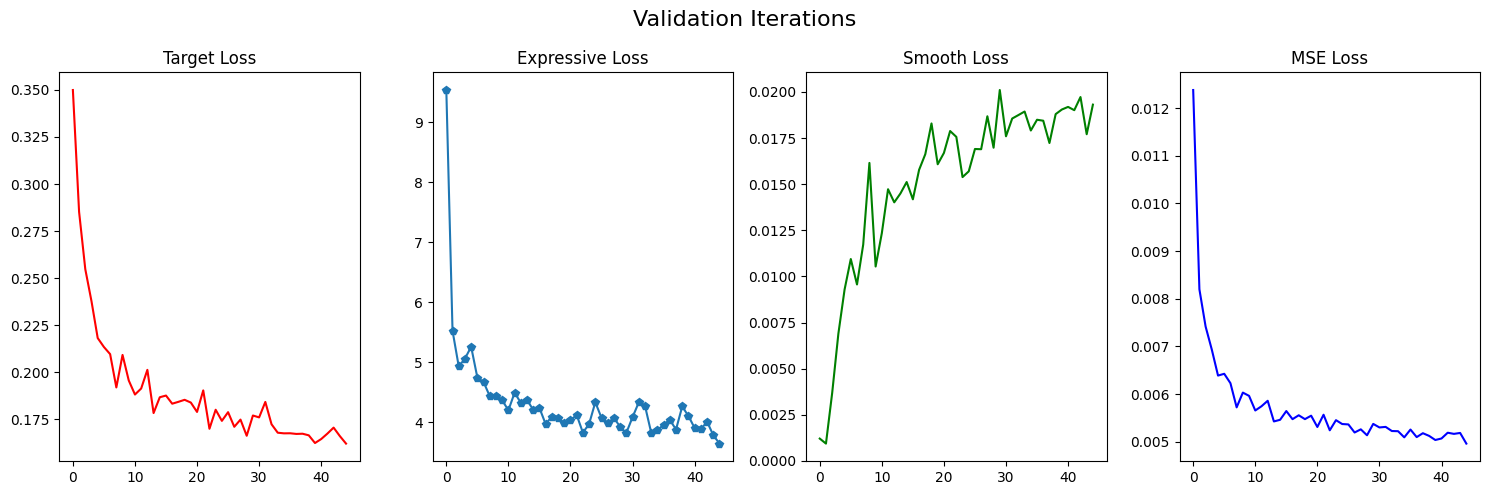

  0%|          | 0/14857 [00:00<?, ?it/s]

[3][0/14857]: [train] [target loss]: 0.15426884591579437 [exp loss]: 2.7733194828033447 [smooth loss]: 0.021193742752075195 [mse]: 0.004420438789738753


  0%|          | 2/14857 [00:11<20:24:32,  4.95s/it]

[3][0/14857]: [val] [target loss]: 0.16739042215049266 [exp loss]: 3.8406231880187987 [smooth loss]: 0.018451899588108063 [mse]: 0.005140422212096374


  3%|▎         | 502/14857 [00:47<17:10, 13.93it/s] 

[3][500/14857]: [train] [target loss]: 0.13198213279247284 [exp loss]: 2.594710350036621 [smooth loss]: 0.016227006912231445 [mse]: 0.004101045913227914


  7%|▋         | 1000/14857 [01:23<16:15, 14.20it/s]

[3][1000/14857]: [train] [target loss]: 0.23446734249591827 [exp loss]: 11.236065864562988 [smooth loss]: 0.025203227996826172 [mse]: 0.006680008945830771


  7%|▋         | 1002/14857 [01:34<6:22:25,  1.66s/it]

[3][1000/14857]: [val] [target loss]: 0.1584424491226673 [exp loss]: 3.9394195747375487 [smooth loss]: 0.018439794480800627 [mse]: 0.004909827441676632


 10%|█         | 1503/14857 [02:11<17:48, 12.50it/s]  

[3][1500/14857]: [train] [target loss]: 0.14998142421245575 [exp loss]: 3.072897434234619 [smooth loss]: 0.025084972381591797 [mse]: 0.004647919660427745


 13%|█▎        | 1999/14857 [02:47<15:32, 13.79it/s]

[3][2000/14857]: [train] [target loss]: 0.1684274971485138 [exp loss]: 2.8542404174804688 [smooth loss]: 0.018129467964172363 [mse]: 0.004742036847643173


 13%|█▎        | 2002/14857 [03:00<6:03:16,  1.70s/it]

[3][2000/14857]: [val] [target loss]: 0.16616202361881732 [exp loss]: 3.805092694759369 [smooth loss]: 0.018639693856239318 [mse]: 0.005009908906831202


 17%|█▋        | 2502/14857 [03:36<14:06, 14.60it/s]  

[3][2500/14857]: [train] [target loss]: 0.1719289869070053 [exp loss]: 3.648113250732422 [smooth loss]: 0.0205533504486084 [mse]: 0.005268874370934576


 20%|██        | 3000/14857 [04:12<14:00, 14.10it/s]

[3][3000/14857]: [train] [target loss]: 0.1859818547964096 [exp loss]: 3.8714706897735596 [smooth loss]: 0.021443307399749756 [mse]: 0.005779009282571503


 20%|██        | 3002/14857 [04:22<5:22:34,  1.63s/it]

[3][3000/14857]: [val] [target loss]: 0.1626302447542548 [exp loss]: 4.0935926234722135 [smooth loss]: 0.018752332627773285 [mse]: 0.005032003462930832


 24%|██▎       | 3503/14857 [04:58<12:51, 14.72it/s]  

[3][3500/14857]: [train] [target loss]: 0.12265157699584961 [exp loss]: 2.092665910720825 [smooth loss]: 0.01688486337661743 [mse]: 0.003838835538266481


 27%|██▋       | 3999/14857 [05:34<13:15, 13.64it/s]

[3][4000/14857]: [train] [target loss]: 0.20128996670246124 [exp loss]: 5.992002487182617 [smooth loss]: 0.022701561450958252 [mse]: 0.005576220076728355


 27%|██▋       | 4002/14857 [05:45<4:20:35,  1.44s/it]

[3][4000/14857]: [val] [target loss]: 0.1646442574635148 [exp loss]: 4.359361916184425 [smooth loss]: 0.020035952627658844 [mse]: 0.005124479374807364


 30%|███       | 4502/14857 [06:23<12:37, 13.68it/s]  

[3][4500/14857]: [train] [target loss]: 0.16152478754520416 [exp loss]: 3.114346742630005 [smooth loss]: 0.020418524742126465 [mse]: 0.005458785533810815


 34%|███▎      | 5000/14857 [06:59<11:49, 13.88it/s]

[3][5000/14857]: [train] [target loss]: 0.1613711565732956 [exp loss]: 3.443389892578125 [smooth loss]: 0.02109503746032715 [mse]: 0.005005392353938954


 34%|███▎      | 5002/14857 [07:11<4:51:13,  1.77s/it]

[3][5000/14857]: [val] [target loss]: 0.157759762480855 [exp loss]: 4.236050837039947 [smooth loss]: 0.019384045004844665 [mse]: 0.004786511101104078


 37%|███▋      | 5503/14857 [07:48<11:18, 13.79it/s]  

[3][5500/14857]: [train] [target loss]: 0.19313554465770721 [exp loss]: 4.639131546020508 [smooth loss]: 0.01337498426437378 [mse]: 0.006421869125254853


 40%|████      | 5999/14857 [08:25<10:50, 13.62it/s]

[3][6000/14857]: [train] [target loss]: 0.14469407498836517 [exp loss]: 2.338179111480713 [smooth loss]: 0.02585136890411377 [mse]: 0.004641408989213151


 40%|████      | 6002/14857 [08:37<3:35:28,  1.46s/it]

[3][6000/14857]: [val] [target loss]: 0.1652756626904011 [exp loss]: 4.050380111336708 [smooth loss]: 0.019356269538402558 [mse]: 0.005059064373212277


 44%|████▍     | 6502/14857 [09:14<10:00, 13.91it/s]  

[3][6500/14857]: [train] [target loss]: 0.1374979466199875 [exp loss]: 2.958242177963257 [smooth loss]: 0.024237751960754395 [mse]: 0.004506832300031788


 47%|████▋     | 7000/14857 [09:51<09:25, 13.89it/s]

[3][7000/14857]: [train] [target loss]: 0.17153990268707275 [exp loss]: 5.060670852661133 [smooth loss]: 0.026029586791992188 [mse]: 0.005948865966867449


 47%|████▋     | 7002/14857 [10:03<3:47:47,  1.74s/it]

[3][7000/14857]: [val] [target loss]: 0.15873128432780503 [exp loss]: 3.6231214559078215 [smooth loss]: 0.018439069986343384 [mse]: 0.00489989770516785


 51%|█████     | 7503/14857 [10:39<08:34, 14.30it/s]  

[3][7500/14857]: [train] [target loss]: 0.14345689117908478 [exp loss]: 2.98868465423584 [smooth loss]: 0.018580913543701172 [mse]: 0.00424168994896003


 54%|█████▍    | 7999/14857 [11:14<08:06, 14.11it/s]

[3][8000/14857]: [train] [target loss]: 0.1780870258808136 [exp loss]: 4.036282062530518 [smooth loss]: 0.02134990692138672 [mse]: 0.00650159158580338


 54%|█████▍    | 8002/14857 [11:24<2:36:28,  1.37s/it]

[3][8000/14857]: [val] [target loss]: 0.15977639213204384 [exp loss]: 4.457381171584129 [smooth loss]: 0.018798800706863402 [mse]: 0.0049465606866899384


 57%|█████▋    | 8502/14857 [12:00<07:47, 13.60it/s]  

[3][8500/14857]: [train] [target loss]: 0.21238155663013458 [exp loss]: 3.7762999534606934 [smooth loss]: 0.018002331256866455 [mse]: 0.00659999549400425


 61%|██████    | 9000/14857 [12:37<07:20, 13.29it/s]

[3][9000/14857]: [train] [target loss]: 0.18243296444416046 [exp loss]: 4.61883544921875 [smooth loss]: 0.02281820774078369 [mse]: 0.005755888695772779


 61%|██████    | 9002/14857 [12:48<2:51:07,  1.75s/it]

[3][9000/14857]: [val] [target loss]: 0.1585643006488681 [exp loss]: 3.9224275833368303 [smooth loss]: 0.020290043354034424 [mse]: 0.004883595979556354


 64%|██████▍   | 9503/14857 [13:25<06:23, 13.98it/s]  

[3][9500/14857]: [train] [target loss]: 0.14940018951892853 [exp loss]: 2.6785149574279785 [smooth loss]: 0.022858798503875732 [mse]: 0.004901076366925693


 67%|██████▋   | 9999/14857 [14:02<05:49, 13.91it/s]

[3][10000/14857]: [train] [target loss]: 0.15709172189235687 [exp loss]: 3.907942771911621 [smooth loss]: 0.020441889762878418 [mse]: 0.004959239179340826


 67%|██████▋   | 10002/14857 [14:13<1:56:35,  1.44s/it]

[3][10000/14857]: [val] [target loss]: 0.15903416100889445 [exp loss]: 3.948331083059311 [smooth loss]: 0.01789078176021576 [mse]: 0.0049198026854175595


 71%|███████   | 10502/14857 [14:51<05:14, 13.85it/s]  

[3][10500/14857]: [train] [target loss]: 0.14964528381824493 [exp loss]: 2.637897253036499 [smooth loss]: 0.017372548580169678 [mse]: 0.004823831304656082


 74%|███████▍  | 11000/14857 [15:28<04:39, 13.81it/s]

[3][11000/14857]: [train] [target loss]: 0.1865331530570984 [exp loss]: 4.073765277862549 [smooth loss]: 0.02070671319961548 [mse]: 0.006385415487609732


 74%|███████▍  | 11002/14857 [15:39<1:50:52,  1.73s/it]

[3][11000/14857]: [val] [target loss]: 0.17142290465533733 [exp loss]: 3.9007951748371124 [smooth loss]: 0.018707115650177002 [mse]: 0.005173583789138862


 77%|███████▋  | 11503/14857 [16:17<04:12, 13.31it/s]  

[3][11500/14857]: [train] [target loss]: 0.16475221514701843 [exp loss]: 3.9095728397369385 [smooth loss]: 0.018261611461639404 [mse]: 0.005460599073233449


 81%|████████  | 11999/14857 [16:55<03:29, 13.67it/s]

[3][12000/14857]: [train] [target loss]: 0.162750244140625 [exp loss]: 3.341860771179199 [smooth loss]: 0.018750011920928955 [mse]: 0.005451791872378427


 81%|████████  | 12002/14857 [17:06<1:09:07,  1.45s/it]

[3][12000/14857]: [val] [target loss]: 0.16561430409550668 [exp loss]: 3.769430034160614 [smooth loss]: 0.02148286610841751 [mse]: 0.0050652453128217055


 84%|████████▍ | 12502/14857 [17:43<02:48, 14.01it/s]  

[3][12500/14857]: [train] [target loss]: 0.128384068608284 [exp loss]: 2.71747088432312 [smooth loss]: 0.0244063138961792 [mse]: 0.003745513042787368


 88%|████████▊ | 13000/14857 [18:21<02:11, 14.10it/s]

[3][13000/14857]: [train] [target loss]: 0.18839329481124878 [exp loss]: 5.791904926300049 [smooth loss]: 0.02182096242904663 [mse]: 0.0054365960887714495


 88%|████████▊ | 13002/14857 [18:32<55:22,  1.79s/it]

[3][13000/14857]: [val] [target loss]: 0.16170291155576705 [exp loss]: 3.661181027293205 [smooth loss]: 0.017715924084186555 [mse]: 0.004868120587852454


 91%|█████████ | 13503/14857 [19:10<01:37, 13.85it/s]

[3][13500/14857]: [train] [target loss]: 0.17188647389411926 [exp loss]: 3.084355354309082 [smooth loss]: 0.01996380090713501 [mse]: 0.004932131781554409


 94%|█████████▍| 13999/14857 [19:47<01:04, 13.39it/s]

[3][14000/14857]: [train] [target loss]: 0.16429582238197327 [exp loss]: 3.355177879333496 [smooth loss]: 0.022609591484069824 [mse]: 0.005234138423457664


 94%|█████████▍| 14002/14857 [19:59<20:36,  1.45s/it]

[3][14000/14857]: [val] [target loss]: 0.1651953522115946 [exp loss]: 3.7169653081893923 [smooth loss]: 0.019474690854549406 [mse]: 0.005122914676776568


 98%|█████████▊| 14502/14857 [20:37<00:25, 13.68it/s]

[3][14500/14857]: [train] [target loss]: 0.18354354798793793 [exp loss]: 3.4683353900909424 [smooth loss]: 0.019188225269317627 [mse]: 0.005200744101066491


100%|██████████| 14857/14857 [21:03<00:00, 11.76it/s]


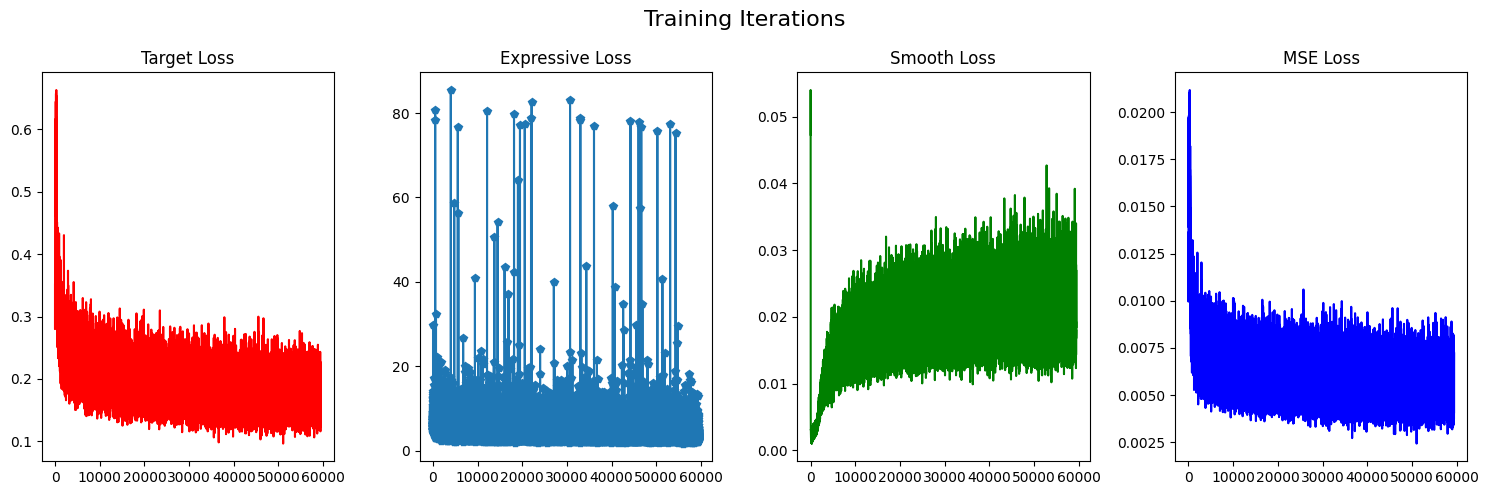

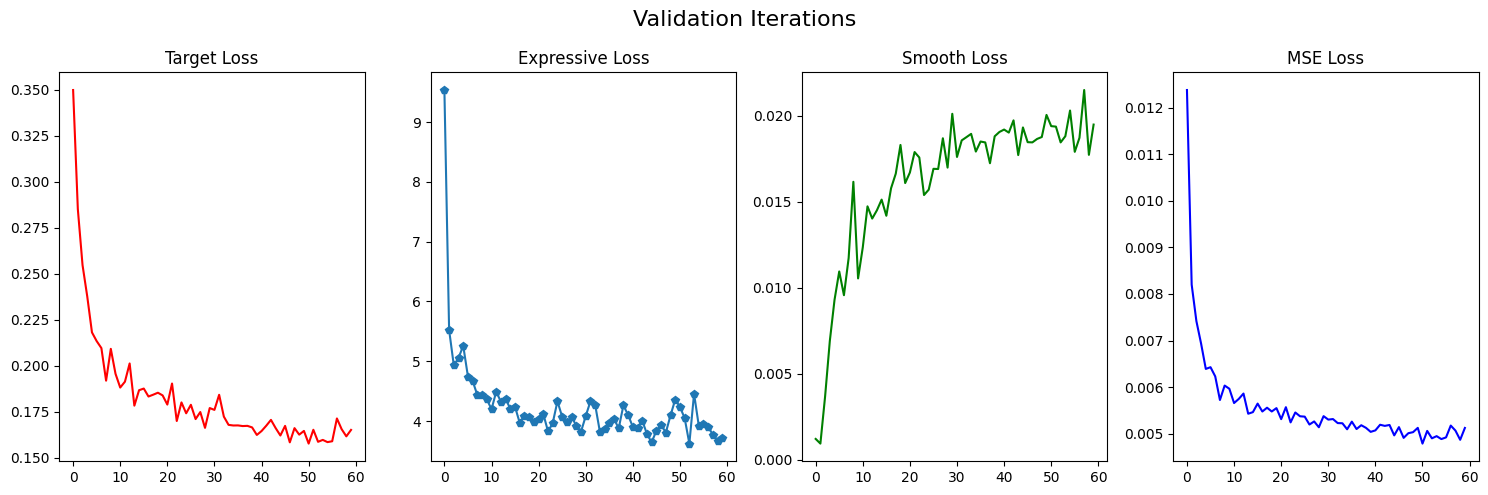

  0%|          | 0/14857 [00:00<?, ?it/s]

[4][0/14857]: [train] [target loss]: 0.165482297539711 [exp loss]: 3.2405714988708496 [smooth loss]: 0.030124306678771973 [mse]: 0.004971287397163385


  0%|          | 2/14857 [00:11<20:18:32,  4.92s/it]

[4][0/14857]: [val] [target loss]: 0.16453156124800444 [exp loss]: 3.7848003625869753 [smooth loss]: 0.020437537133693694 [mse]: 0.00498049962479114


  3%|▎         | 503/14857 [00:47<16:24, 14.57it/s] 

[4][500/14857]: [train] [target loss]: 0.18102604150772095 [exp loss]: 3.1963303089141846 [smooth loss]: 0.030468285083770752 [mse]: 0.0053246247297747675


  7%|▋         | 999/14857 [01:24<17:47, 12.98it/s]

[4][1000/14857]: [train] [target loss]: 0.1715298742055893 [exp loss]: 3.3068008422851562 [smooth loss]: 0.03252053260803223 [mse]: 0.005583939240099801


  7%|▋         | 1002/14857 [01:36<5:49:17,  1.51s/it]

[4][1000/14857]: [val] [target loss]: 0.1603480875864625 [exp loss]: 3.8987387025356295 [smooth loss]: 0.01973987489938736 [mse]: 0.004964965528831309


 10%|█         | 1502/14857 [02:12<15:53, 14.01it/s]  

[4][1500/14857]: [train] [target loss]: 0.20820434391498566 [exp loss]: 5.832098960876465 [smooth loss]: 0.018836140632629395 [mse]: 0.005722076907132205


 13%|█▎        | 2000/14857 [02:50<16:05, 13.32it/s]

[4][2000/14857]: [train] [target loss]: 0.18902628123760223 [exp loss]: 3.658273220062256 [smooth loss]: 0.02180778980255127 [mse]: 0.005622515518305946


 13%|█▎        | 2002/14857 [03:01<6:14:42,  1.75s/it]

[4][2000/14857]: [val] [target loss]: 0.16480310697108508 [exp loss]: 3.9929949164390566 [smooth loss]: 0.01938854157924652 [mse]: 0.005105382421008455


 17%|█▋        | 2503/14857 [03:39<15:01, 13.70it/s]  

[4][2500/14857]: [train] [target loss]: 0.17611436545848846 [exp loss]: 3.07110857963562 [smooth loss]: 0.026058077812194824 [mse]: 0.005608223229525722


 20%|██        | 2999/14857 [04:16<14:22, 13.75it/s]

[4][3000/14857]: [train] [target loss]: 0.1870400458574295 [exp loss]: 4.463258266448975 [smooth loss]: 0.020344555377960205 [mse]: 0.00575397780088382


 20%|██        | 3002/14857 [04:27<4:59:35,  1.52s/it]

[4][3000/14857]: [val] [target loss]: 0.16103324182331563 [exp loss]: 3.9500308573246 [smooth loss]: 0.020035635828971863 [mse]: 0.004986558682608428


 24%|██▎       | 3502/14857 [05:04<13:12, 14.33it/s]  

[4][3500/14857]: [train] [target loss]: 0.1839759349822998 [exp loss]: 3.8081507682800293 [smooth loss]: 0.01909959316253662 [mse]: 0.006654754061336962


 27%|██▋       | 4000/14857 [05:39<12:46, 14.17it/s]

[4][4000/14857]: [train] [target loss]: 0.17518733441829681 [exp loss]: 3.9378600120544434 [smooth loss]: 0.025849521160125732 [mse]: 0.005362218803487845


 27%|██▋       | 4002/14857 [05:50<5:04:10,  1.68s/it]

[4][4000/14857]: [val] [target loss]: 0.1659533568099141 [exp loss]: 4.115465571284294 [smooth loss]: 0.01796672582626343 [mse]: 0.0050358614975101615


 30%|███       | 4503/14857 [06:26<11:55, 14.47it/s]  

[4][4500/14857]: [train] [target loss]: 0.17052024602890015 [exp loss]: 2.7220065593719482 [smooth loss]: 0.015734314918518066 [mse]: 0.005263991998334432


 34%|███▎      | 4999/14857 [07:01<12:10, 13.49it/s]

[4][5000/14857]: [train] [target loss]: 0.15384311974048615 [exp loss]: 3.2483277320861816 [smooth loss]: 0.020288944244384766 [mse]: 0.004801066788111178


 34%|███▎      | 5002/14857 [07:12<3:52:40,  1.42s/it]

[4][5000/14857]: [val] [target loss]: 0.15942067984491587 [exp loss]: 4.011705525517463 [smooth loss]: 0.019557895064353945 [mse]: 0.004926857356569869


 37%|███▋      | 5502/14857 [07:50<11:29, 13.56it/s]  

[4][5500/14857]: [train] [target loss]: 0.17729806900024414 [exp loss]: 3.6430776119232178 [smooth loss]: 0.023974061012268066 [mse]: 0.005382549732431335


 40%|████      | 6000/14857 [08:27<10:54, 13.54it/s]

[4][6000/14857]: [train] [target loss]: 0.16096539795398712 [exp loss]: 2.562364101409912 [smooth loss]: 0.021007061004638672 [mse]: 0.005294481741036184


 40%|████      | 6002/14857 [08:39<4:34:03,  1.86s/it]

[4][6000/14857]: [val] [target loss]: 0.15950827598571776 [exp loss]: 4.021626519560814 [smooth loss]: 0.021130342185497284 [mse]: 0.004915066476484199


 44%|████▍     | 6503/14857 [09:17<10:34, 13.17it/s]  

[4][6500/14857]: [train] [target loss]: 0.16216780245304108 [exp loss]: 3.2106075286865234 [smooth loss]: 0.02207469940185547 [mse]: 0.00486174727921419


 47%|████▋     | 6999/14857 [09:55<09:35, 13.65it/s]

[4][7000/14857]: [train] [target loss]: 0.14285185933113098 [exp loss]: 2.523899793624878 [smooth loss]: 0.02035081386566162 [mse]: 0.0041379483243602


 47%|████▋     | 7002/14857 [10:07<3:16:20,  1.50s/it]

[4][7000/14857]: [val] [target loss]: 0.16412114437669514 [exp loss]: 4.0846221423149105 [smooth loss]: 0.018570878505706788 [mse]: 0.0050570536030080816


 50%|█████     | 7502/14857 [10:44<08:57, 13.70it/s]  

[4][7500/14857]: [train] [target loss]: 0.17475241422653198 [exp loss]: 5.510822772979736 [smooth loss]: 0.018299520015716553 [mse]: 0.0054441965548838265


 54%|█████▍    | 8000/14857 [11:22<08:13, 13.89it/s]

[4][8000/14857]: [train] [target loss]: 0.16218645870685577 [exp loss]: 3.381464719772339 [smooth loss]: 0.014937877655029297 [mse]: 0.005517352797800447


 54%|█████▍    | 8002/14857 [11:33<3:15:47,  1.71s/it]

[4][8000/14857]: [val] [target loss]: 0.15425874307751655 [exp loss]: 3.7833645302057266 [smooth loss]: 0.018885066211223604 [mse]: 0.004757888229311663


 57%|█████▋    | 8503/14857 [12:10<07:50, 13.51it/s]  

[4][8500/14857]: [train] [target loss]: 0.14590661227703094 [exp loss]: 2.6583542823791504 [smooth loss]: 0.02284306287765503 [mse]: 0.004662363953037455


 61%|██████    | 8999/14857 [12:47<07:20, 13.30it/s]

[4][9000/14857]: [train] [target loss]: 0.13938210904598236 [exp loss]: 2.4685587882995605 [smooth loss]: 0.021490931510925293 [mse]: 0.004245400635378299


 61%|██████    | 9002/14857 [12:59<2:24:43,  1.48s/it]

[4][9000/14857]: [val] [target loss]: 0.1539384699985385 [exp loss]: 3.8105762457847594 [smooth loss]: 0.01837503373622894 [mse]: 0.004805545524253543


 64%|██████▍   | 9502/14857 [13:37<07:02, 12.66it/s]  

[4][9500/14857]: [train] [target loss]: 0.21916398406028748 [exp loss]: 4.559780597686768 [smooth loss]: 0.022334933280944824 [mse]: 0.00716862056333114


 67%|██████▋   | 10000/14857 [14:14<05:50, 13.84it/s]

[4][10000/14857]: [train] [target loss]: 0.1936909407377243 [exp loss]: 4.197837829589844 [smooth loss]: 0.01930004358291626 [mse]: 0.006473834112175297


 67%|██████▋   | 10002/14857 [14:26<2:14:58,  1.67s/it]

[4][10000/14857]: [val] [target loss]: 0.1647744358703494 [exp loss]: 3.9048861414194107 [smooth loss]: 0.02010995417833328 [mse]: 0.00505064137526012


 71%|███████   | 10502/14857 [15:04<05:21, 13.55it/s]  

[4][10500/14857]: [train] [target loss]: 0.18596629798412323 [exp loss]: 4.697153568267822 [smooth loss]: 0.0192410945892334 [mse]: 0.006559188974456393


 74%|███████▍  | 11000/14857 [15:42<04:51, 13.24it/s]

[4][11000/14857]: [train] [target loss]: 0.16111546754837036 [exp loss]: 4.279179096221924 [smooth loss]: 0.024257302284240723 [mse]: 0.004944594552209023


 74%|███████▍  | 11002/14857 [15:53<1:52:05,  1.74s/it]

[4][11000/14857]: [val] [target loss]: 0.1576376720517874 [exp loss]: 4.191981725692749 [smooth loss]: 0.018219932317733764 [mse]: 0.004860545581443819


 77%|███████▋  | 11503/14857 [16:30<03:59, 14.00it/s]  

[4][11500/14857]: [train] [target loss]: 0.12682205438613892 [exp loss]: 2.3432729244232178 [smooth loss]: 0.02562028169631958 [mse]: 0.00364095906306497


 81%|████████  | 11999/14857 [17:11<05:11,  9.17it/s]

[4][12000/14857]: [train] [target loss]: 0.1859106868505478 [exp loss]: 4.21584415435791 [smooth loss]: 0.022065937519073486 [mse]: 0.006948951086667315


 81%|████████  | 12002/14857 [17:22<1:32:18,  1.94s/it]

[4][12000/14857]: [val] [target loss]: 0.16137041382491588 [exp loss]: 3.627536722421646 [smooth loss]: 0.019721866846084596 [mse]: 0.005020696066295569


 84%|████████▍ | 12502/14857 [17:58<02:42, 14.51it/s]  

[4][12500/14857]: [train] [target loss]: 0.20616415143013 [exp loss]: 3.9654343128204346 [smooth loss]: 0.019523143768310547 [mse]: 0.006694906391294658


 88%|████████▊ | 13000/14857 [18:32<02:06, 14.66it/s]

[4][13000/14857]: [train] [target loss]: 0.16417662799358368 [exp loss]: 3.379743814468384 [smooth loss]: 0.019295871257781982 [mse]: 0.005287425259215048


 88%|████████▊ | 13002/14857 [18:43<49:09,  1.59s/it]

[4][13000/14857]: [val] [target loss]: 0.15563097335398196 [exp loss]: 3.638177225589752 [smooth loss]: 0.020977123379707335 [mse]: 0.0048695116521443645


 91%|█████████ | 13502/14857 [19:19<01:34, 14.33it/s]

[4][13500/14857]: [train] [target loss]: 0.1812315285205841 [exp loss]: 5.10965633392334 [smooth loss]: 0.020886719226837158 [mse]: 0.005683981412416967


 94%|█████████▍| 14000/14857 [19:54<00:59, 14.44it/s]

[4][14000/14857]: [train] [target loss]: 0.1680527627468109 [exp loss]: 5.6838908195495605 [smooth loss]: 0.018815815448760986 [mse]: 0.004880168520235982


 94%|█████████▍| 14002/14857 [20:04<23:00,  1.61s/it]

[4][14000/14857]: [val] [target loss]: 0.15670678175985814 [exp loss]: 3.722491973042488 [smooth loss]: 0.019924996495246886 [mse]: 0.004799396732674255


 98%|█████████▊| 14502/14857 [20:41<00:30, 11.83it/s]

[4][14500/14857]: [train] [target loss]: 0.13605348765850067 [exp loss]: 2.154493808746338 [smooth loss]: 0.023116469383239746 [mse]: 0.004086792998695599


100%|██████████| 14857/14857 [21:07<00:00, 11.72it/s]


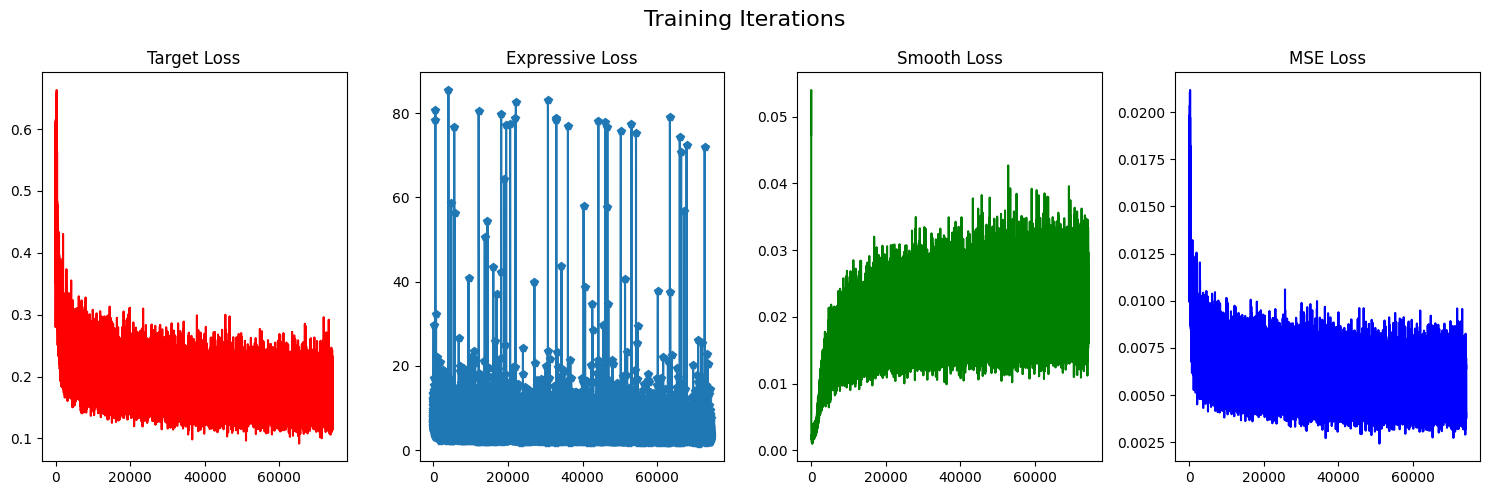

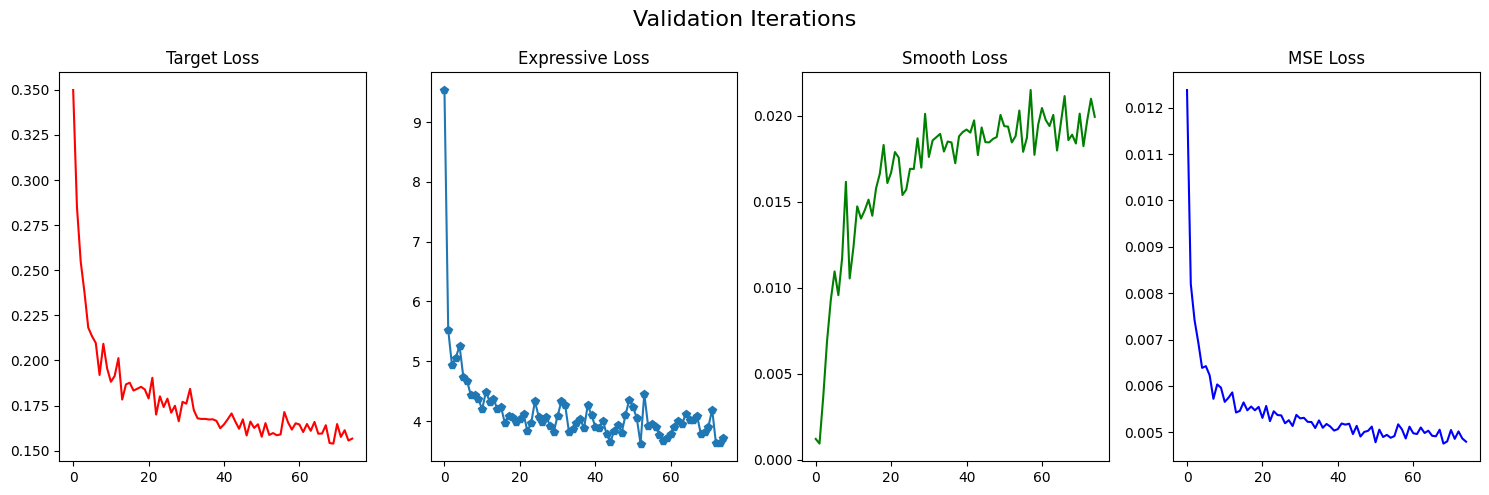

In [45]:
from tqdm import tqdm
num_epochs = 5
log_period = 500
val_period = 1000
val_size = 200
target_loss_function = torch.nn.HuberLoss()
smooth_loss_function = torch.nn.CosineSimilarity(dim=2)
mse_loss_function = torch.nn.MSELoss()
target_weight = 1.5
expressive_weight = 0.5
smooth_weight = 0.5

for epoch in range(num_epochs):
    for it, data in enumerate(tqdm(train_loader)):
        net.train()
        in_audio = data['audio']
        facial = data['facial']

        in_audio = in_audio.cuda()
        facial = facial.cuda()
        pre_frames = 4
        in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
        in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
        in_pre_face[:, 0:pre_frames, -1] = 1 
        
        optimizer.zero_grad()
        out_face = net(in_pre_face,in_audio)
        target_loss = target_loss_function(out_face, facial)
        expressive_loss = expressive_loss_function(out_face, facial)
        smooth_loss = 1 - smooth_loss_function(out_face[:,:-1,:], out_face[:,1:,:]).mean()
        loss = target_weight * target_loss + expressive_weight * expressive_loss + smooth_weight * smooth_loss
        loss.backward()
        optimizer.step()
        
        train_target_loss.append(target_loss.item())
        train_expressive_loss.append(expressive_loss.item())
        train_smooth_loss.append(smooth_loss.item())
        train_mse_loss.append(mse_loss_function(out_face.cpu()*std_facial+mean_facial, facial.cpu()*std_facial+mean_facial).item())
        
        #logging
        if it % log_period == 0:
            print(f'[{epoch}][{it}/{len(train_loader)}]: [train] [target loss]: {train_target_loss[-1]} [exp loss]: {train_expressive_loss[-1]} [smooth loss]: {train_smooth_loss[-1]} [mse]: {train_mse_loss[-1]}')
        
        if it % val_period == 0:
            net.eval()
            val_target_loss_st = []
            val_expressive_loss_st = []
            val_smooth_loss_st = []
            val_mse_loss_st = []
            val_cnt = 0
            
            for _, data in enumerate(val_loader):
                in_audio = data['audio']
                facial = data['facial']
                in_audio = in_audio.cuda()
                facial = facial.cuda()
                pre_frames = 4
                in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
                in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
                in_pre_face[:, 0:pre_frames, -1] = 1 

                out_face = net(in_pre_face,in_audio)
                target_loss = target_loss_function(out_face, facial) 
                expressive_loss = expressive_loss_function(out_face, facial)
                smooth_loss = 1 - smooth_loss_function(out_face[:,:-1,:], out_face[:,1:,:]).mean()

                val_target_loss_st.append(target_loss.item())
                val_expressive_loss_st.append(expressive_loss.item())
                val_smooth_loss_st.append(smooth_loss.item())
                val_mse_loss_st.append(mse_loss_function(out_face.cpu()*std_facial+mean_facial, facial.cpu()*std_facial+mean_facial).item())
                
                
                val_cnt += 1
                if val_cnt >= val_size:
                    break
            
            val_target_loss.append(np.average(val_target_loss_st))
            val_expressive_loss.append(np.average(val_expressive_loss_st))
            val_smooth_loss.append(np.average(val_smooth_loss_st))
            val_mse_loss.append(np.average(val_mse_loss_st))
            print(f'[{epoch}][{it}/{len(train_loader)}]: [val] [target loss]: {val_target_loss[-1]} [exp loss]: {val_expressive_loss[-1]} [smooth loss]: {val_smooth_loss[-1]} [mse]: {val_mse_loss[-1]}')
    plot_train_val_loss()
        

In [46]:
torch.save(net.state_dict(), 'ckpt_model/simplenet3.pth')

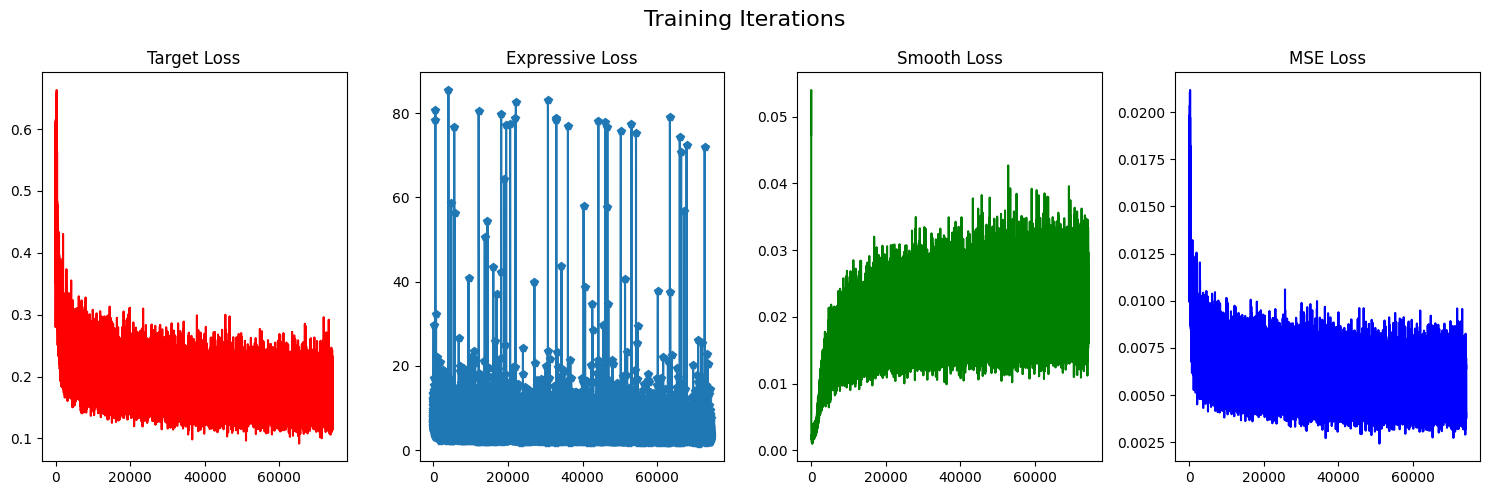

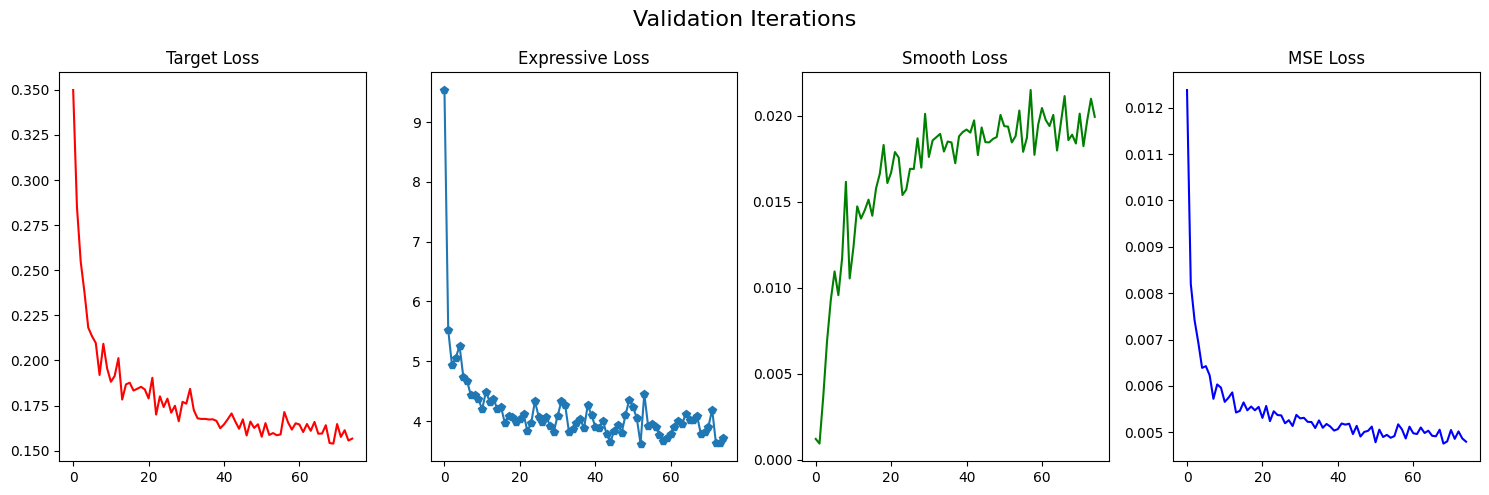

In [47]:
plot_train_val_loss()

### Testing

In [1]:
from pythonosc import udp_client
import time
import sounddevice as sd
import torch
from dataloaders.beat import CustomDataset
from dataloaders.build_vocab import Vocab
import pickle
import numpy as np

config_file = open("camn_config.obj", 'rb') 
args = pickle.load(config_file)
args.batch_size = 16

mean_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_mean.npy"))
std_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_std.npy"))
mean_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_mean.npy"))
std_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_std.npy"))

In [2]:
test_data = CustomDataset(args, "test")
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=1,  
    shuffle=True,  
    drop_last=False,
)

In [3]:
data = next(iter(test_loader))

In [4]:
facial = data["facial"]
audio = data["audio"]

In [5]:
out_facial = facial * std_facial + mean_facial
out_audio = audio * std_audio + mean_audio

In [6]:
# Try playing the audio, which is at 16KHZ
print(out_facial.min(), out_facial.max())
print(out_facial.std(), out_facial.mean())

tensor(-2.9796e-09, dtype=torch.float64) tensor(0.9345, dtype=torch.float64)
tensor(0.1866, dtype=torch.float64) tensor(0.1691, dtype=torch.float64)


In [7]:
out_audio.shape

torch.Size([1, 1152000])

In [8]:
blend =  [
        "browDownLeft",
        "browDownRight",
        "browInnerUp",
        "browOuterUpLeft",
        "browOuterUpRight",
        "cheekPuff",
        "cheekSquintLeft",
        "cheekSquintRight",
        "eyeBlinkLeft",
        "eyeBlinkRight",
        "eyeLookDownLeft",
        "eyeLookDownRight",
        "eyeLookInLeft",
        "eyeLookInRight",
        "eyeLookOutLeft",
        "eyeLookOutRight",
        "eyeLookUpLeft",
        "eyeLookUpRight",
        "eyeSquintLeft",
        "eyeSquintRight",
        "eyeWideLeft",
        "eyeWideRight",
        "jawForward",
        "jawLeft",
        "jawOpen",
        "jawRight",
        "mouthClose",
        "mouthDimpleLeft",
        "mouthDimpleRight",
        "mouthFrownLeft",
        "mouthFrownRight",
        "mouthFunnel",
        "mouthLeft",
        "mouthLowerDownLeft",
        "mouthLowerDownRight",
        "mouthPressLeft",
        "mouthPressRight",
        "mouthPucker",
        "mouthRight",
        "mouthRollLower",
        "mouthRollUpper",
        "mouthShrugLower",
        "mouthShrugUpper",
        "mouthSmileLeft",
        "mouthSmileRight",
        "mouthStretchLeft",
        "mouthStretchRight",
        "mouthUpperUpLeft",
        "mouthUpperUpRight",
        "noseSneerLeft",
        "noseSneerRight",
        "tongueOut"
    ]

In [9]:
def play_audio(out_audio, init_time):
    time.sleep(init_time - time.time())
    sd.play(out_audio, 16000)
    sd.wait()
    print("Audio finished:", time.time())

In [10]:

def send_udp(out_face, init_time):
    #outWeight = np.zeros(52)

    ##need to implement get value in
    outWeight = out_face

    outWeight = outWeight * (outWeight >= 0)

    client = udp_client.SimpleUDPClient('127.0.0.1', 5008)
    osc_array = outWeight.tolist()
    
    fps = 15
    time.sleep(init_time - time.time())
    #start_time = time.time()
    for i in range(len(osc_array)):
        #print(out_face[i].shape)
        for j, out in enumerate(osc_array[i]):
            client.send_message('/' + str(blend[j]), out)

        elpased_time = time.time() - init_time
        sleep_time = 1.0/fps * (i+1) - elpased_time
        if sleep_time > 0:
            time.sleep(sleep_time)
        #start_time = time.time()
    print("Facial finished:", time.time())

In [11]:
import threading

init_time = time.time() + 1

limit_sec = 20

udp_thread = threading.Thread(target=send_udp, args=(out_facial[0, 0:limit_sec*15],init_time))
udp_thread.daemon = True  # Set the thread as a daemon to allow it to exit when the main program exits

audio_thread = threading.Thread(target=play_audio, args=(out_audio[0, 0:limit_sec*16000],init_time))
audio_thread.daemon = True

udp_thread.start()
audio_thread.start()

udp_thread.join()
audio_thread.join()

Facial finished: 1715114662.0617156
Audio finished: 1715114662.5492146


In [12]:
print(len(out_audio[0])/16000, len(out_facial[0])/15)

72.0 72.0


In [13]:
 # load in model
from scripts.SimpleNet import FaceGenerator
model_path = 'ckpt_model/simplenet3.pth'
net = FaceGenerator()
net.load_state_dict(torch.load(model_path))
net = net.cuda().eval()

In [14]:
in_audio = audio.cuda()
in_facial = facial.cuda()
pre_frames = 4
in_pre_facial = in_facial.new_zeros((in_facial.shape[0], in_facial.shape[1], in_facial.shape[2] + 1)).cuda() #-5 for now for temp bug fix
in_pre_facial[:, 0:pre_frames, :-1] = in_facial[:, 0:pre_frames]
in_pre_facial[:, 0:pre_frames, -1] = 1 

pred_facial = net(in_pre_facial,in_audio).cpu().detach()
pred_facial = np.array(pred_facial * std_facial + mean_facial)

In [15]:
print(pred_facial.min(), pred_facial.max())
print(pred_facial.std(), pred_facial.mean())

-0.07818466895675959 0.7661063691079228
0.12739153407061846 0.15293778173224462


In [24]:
import threading

init_time = time.time() + 1

limit_sec = 30

udp_thread = threading.Thread(target=send_udp, args=(pred_facial[0,0:limit_sec*15],init_time))
udp_thread.daemon = True  # Set the thread as a daemon to allow it to exit when the main program exits

audio_thread = threading.Thread(target=play_audio, args=(out_audio[0,0:limit_sec*16000],init_time))
audio_thread.daemon = True

udp_thread.start()
audio_thread.start()

udp_thread.join()
audio_thread.join()

Facial finished: 1715114843.8827715
Audio finished: 1715114844.3323371


In [20]:
print(expressive_loss_function(torch.from_numpy(pred_facial), out_facial))
print(torch.nn.functional.mse_loss(torch.from_numpy(pred_facial), out_facial))

tensor(0.1760, dtype=torch.float64)
tensor(0.0178, dtype=torch.float64)


In [21]:
print(pred_facial.shape)
print(out_facial.shape)

(1, 1080, 51)
torch.Size([1, 1080, 51])


In [22]:
print(pred_facial[:,0,:])

[[ 8.73752973e-03  7.89014494e-03  4.63134123e-01  3.21614527e-01
   3.18027932e-01  4.04698062e-02  3.32072330e-01  3.63076249e-01
  -4.38581960e-04  1.79442354e-03  3.72705275e-02  3.71611128e-02
   2.52829250e-01  7.12454520e-03 -8.49294065e-03  1.61670726e-01
   6.11311772e-02  6.46500007e-02  2.13785962e-01  2.13844659e-01
   6.46099709e-01  6.45870604e-01  9.93512084e-02  2.69829253e-02
   9.15337754e-02  5.23031276e-03  1.44230817e-01  1.06246972e-01
   1.04340959e-01 -1.44008142e-03 -8.50066728e-03  1.88509147e-01
   1.68735657e-03  2.65821328e-01  2.80343588e-01  8.75092674e-02
   9.11398783e-02  8.77053599e-02  2.70951733e-02  1.10258610e-01
   3.39444860e-02  1.29605886e-01  3.04498416e-01  4.63644027e-01
   4.48266173e-01  2.09965860e-01  2.19249496e-01  6.57829263e-02
   8.45406718e-02  1.80118444e-01  2.15634837e-01]]


In [23]:
print(out_facial[:,0,:])

tensor([[-2.9796e-09,  2.9830e-10,  3.9337e-01,  3.0616e-01,  3.0616e-01,
          3.9733e-02,  3.3691e-01,  3.6664e-01,  2.3921e-09, -1.5930e-09,
         -1.6359e-09, -1.9321e-09,  2.8902e-01, -1.2130e-09,  2.0412e-10,
          1.8814e-01,  5.3116e-02,  5.3499e-02,  2.1578e-01,  2.1587e-01,
          6.9715e-01,  6.9714e-01,  9.3386e-02,  3.6447e-02,  1.2060e-01,
         -2.2760e-10,  1.2059e-01,  9.0213e-02,  8.9113e-02,  1.0432e-10,
         -1.1158e-11,  1.8666e-01,  3.4156e-11,  2.7215e-01,  2.8212e-01,
          9.3862e-02,  9.3765e-02,  1.1622e-01,  2.1497e-02,  1.1356e-01,
          4.3822e-02,  1.3656e-01,  3.0891e-01,  5.2099e-01,  5.3139e-01,
          1.8944e-01,  1.8909e-01,  5.9438e-02,  6.6550e-02,  1.5507e-01,
          1.8109e-01]], dtype=torch.float64)
